# Boston Airbnb Analysis

## Objective

The prime objective of this analysis is to identify what features of an Airbnb listing and/or property will lead to a higher revenue. The following questions can be answered post analysis:
1. How much revenue do Airbnb hosts make?
2. Which are the best type of property to rent?
3. When is the best time to rent?
4. Which are the best areas to rent?
5. What should you write in a listing name to maximize revenue?

## Importing and downloading libraries

In [1]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import string
from wordcloud import WordCloud,ImageColorGenerator
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
import shap

In [77]:
# Uncomment below if not downloaded these packages beforehand

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

In [3]:
# Reading in google maps api key. This is required for bokeh gmaps
file = open("my_api_key.txt","r")
MY_API_KEY = file.read()

# Replace with your own google map api
# MY_API_KEY = ""

## Read Data

In [2]:
bos_listings = pd.read_csv("boston-airbnb-open-data/listings.csv")
bos_calendar = pd.read_csv("boston-airbnb-open-data/calendar.csv")
bos_reviews = pd.read_csv("boston-airbnb-open-data/reviews.csv")

In [3]:
bos_listings.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview        ...          \
0  Roslindale is quiet, convenient and friendly. ...        ...           
1  The room is in Roslindale, a diverse and prima...        ...           
2  The LOCATION: Roslindale is a safe and diverse...        ...           
3  Roslindale is a lovely little neighborhood loc...        ...           
4  I love the proximity to downtown, the neighbor...        ...           

  review_scores_value requires_license license jurisdiction_names  \
0                 NaN                f     NaN                NaN   
1                 9.0                f     NaN                NaN   
2                10.0                f     NaN                NaN   
3                10.0                f     NaN                NaN   
4                10.0                f     NaN                NaN   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                t            moderate                             f   
2                f            moderate                             t   
3                f            moderate                             f   
4                f            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

   reviews_per_month  
0                NaN  
1               1.30  
2               0.47  
3               1.00  
4               2.25  

[5 rows x 95 columns]

In [4]:
bos_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## Clean Data

In [5]:
def clean_df(listings_df, calendar_df, reviews_df):
    """
    Return cleaned datasets with all string variables for price, weekly_price, monthly_price,
    security_deposit, cleaning_fee, extra_people replaced with float variables without the dollar
    sign $. Also replace all string variables for host_response_rate, host_acceptance_rate with
    float variables without the percentage sign %. Lastly convert all dates in reviews and calendar
    dataframe with datetime.
    
    INPUTS:
        listings_df - dataframe for listings
        calendar_df - dataframe for calendar
        reviews_df - dataframe for reviews
    OUTPUTS:
        listings_df - cleaned dataframe for listings. 
        calendar_df - cleaned dataframe for calendar
        reviews_df - cleaned dataframe for reviews

    """
    # Convert string of prices to floats
    listings_df.price=listings_df.price.str.replace('$','')
    listings_df.price=listings_df.price.str.replace(',','').astype(float)

    listings_df.weekly_price=listings_df.weekly_price.str.replace('$','')
    listings_df.weekly_price=listings_df.weekly_price.str.replace(',','').astype(float)

    listings_df.monthly_price=listings_df.monthly_price.str.replace('$','')
    listings_df.monthly_price=listings_df.monthly_price.str.replace(',','').astype(float)

    listings_df.security_deposit=listings_df.security_deposit.str.replace('$','')
    listings_df.security_deposit=listings_df.security_deposit.str.replace(',','').astype(float)

    listings_df.cleaning_fee=listings_df.cleaning_fee.str.replace('$','')
    listings_df.cleaning_fee=listings_df.cleaning_fee.str.replace(',','').astype(float)

    listings_df.extra_people=listings_df.extra_people.str.replace('$','')
    listings_df.extra_people=listings_df.extra_people.str.replace(',','').astype(float)

    calendar_df.price = calendar_df.price.str.replace('$','')
    calendar_df.price = calendar_df.price.str.replace(',','').astype(float)

    # Convert string of pecentages to floats
    listings_df.host_response_rate = listings_df.host_response_rate.str.replace('%','')
    listings_df.host_response_rate = listings_df.host_response_rate.astype(float)

    listings_df.host_acceptance_rate = listings_df.host_acceptance_rate.str.replace('%','')
    listings_df.host_acceptance_rate = listings_df.host_acceptance_rate.astype(float)

    # Convert date string to datetime
    reviews_df['date'] = pd.to_datetime(reviews_df['date'], format='%Y-%m-%d')
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')
    
    return listings_df, calendar_df, reviews_df

In [6]:
# clean the dataframes
bos_listings, bos_calendar, bos_reviews = clean_df(bos_listings, bos_calendar, bos_reviews)

In [7]:
def generate_2015_reviews_df(reviews_df):
    """
    Aggregate number of reviews in 2015 for each listing_id. This will serve as an estimate
    for the number of bookings in 2015
    
    INPUTS:
        reviews_df - dataframe for reviews
    OUTPUTS:
        reviews_df_2015_agg - dataframe containing number of reviews per listing_id in 2015
    """
    # Get list of reviews in 2015
    reviews_df_2015 = reviews_df[(reviews_df.date >= '2015-01-01') & (reviews_df.date < '2016-01-01')]
    
    reviews_df_2015_agg = reviews_df_2015.groupby(['listing_id']).agg({'id':'count'})
    reviews_df_2015_agg.rename(index=str, columns={"id": "number_of_reviews_2015"},inplace=True)
    reviews_df_2015_agg['listing_id'] = reviews_df_2015_agg.index.astype('int64')
    
    return reviews_df_2015_agg

In [8]:
bos_reviews_2015_agg = generate_2015_reviews_df(bos_reviews)
bos_reviews_2015_agg.head()

number_of_reviews_2015  listing_id
listing_id                                    
3353                             8        3353
5506                             3        5506
6695                             2        6695
6976                             7        6976
8792                             7        8792

## Understanding the data

In [86]:
bos_listings.groupby(['room_type']).agg({'id':'count'})

id
room_type            
Entire home/apt  2127
Private room     1378
Shared room        80

In [87]:
bos_listings.groupby(['property_type']).agg({'id':'count'})

id
property_type        
Apartment        2612
Bed & Breakfast    41
Boat               12
Camper/RV           1
Condominium       231
Dorm                2
Entire Floor        4
Guesthouse          1
House             562
Loft               39
Other              17
Townhouse          54
Villa               6

In [88]:
bos_listings.groupby(['property_type', 'room_type']).agg({'id':'count'})

id
property_type   room_type            
Apartment       Entire home/apt  1764
                Private room      786
                Shared room        62
Bed & Breakfast Entire home/apt     2
                Private room       38
                Shared room         1
Boat            Entire home/apt    10
                Private room        2
Camper/RV       Entire home/apt     1
Condominium     Entire home/apt   150
                Private room       79
                Shared room         2
Dorm            Private room        2
Entire Floor    Entire home/apt     2
                Private room        2
Guesthouse      Entire home/apt     1
House           Entire home/apt   148
                Private room      405
                Shared room         9
Loft            Entire home/apt    29
                Private room        8
                Shared room         2
Other           Entire home/apt     2
                Private room       11
                Shared room         4
Townhouse       Entire home/apt    14
                Private room       40
Villa           Entire home/apt     2
                Private room        4

In [89]:
bos_listings.isnull().mean()[:50]

id                              0.000000
listing_url                     0.000000
scrape_id                       0.000000
last_scraped                    0.000000
name                            0.000000
summary                         0.039888
space                           0.294840
description                     0.000000
experiences_offered             0.000000
neighborhood_overview           0.394700
notes                           0.550907
transit                         0.359833
access                          0.415342
interaction                     0.433473
house_rules                     0.332497
thumbnail_url                   0.167085
medium_url                      0.167085
picture_url                     0.000000
xl_picture_url                  0.167085
host_id                         0.000000
host_url                        0.000000
host_name                       0.000000
host_since                      0.000000
host_location                   0.003068
host_about      

In [90]:
bos_listings.isnull().mean()[50:]

is_location_exact                   0.000000
property_type                       0.000837
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.003905
bedrooms                            0.002789
beds                                0.002510
bed_type                            0.000000
amenities                           0.000000
square_feet                         0.984379
price                               0.000000
weekly_price                        0.751185
monthly_price                       0.752301
security_deposit                    0.625662
cleaning_fee                        0.308787
guests_included                     0.000000
extra_people                        0.000000
minimum_nights                      0.000000
maximum_nights                      0.000000
calendar_updated                    0.000000
has_availability                    1.000000
availability_30                     0.000000
availabili

In [91]:
bos_calendar.head()

listing_id       date available  price
0    12147973 2017-09-05         f    NaN
1    12147973 2017-09-04         f    NaN
2    12147973 2017-09-03         f    NaN
3    12147973 2017-09-02         f    NaN
4    12147973 2017-09-01         f    NaN

In [92]:
bos_calendar['available'].value_counts(dropna=False)

f    665853
t    643037
Name: available, dtype: int64

In [93]:
# Most listings have 365 days. So we have all year data
bos_availability = bos_calendar.groupby(['listing_id']).available.count()
bos_availability.head()

listing_id
3353    365
5506    365
6695    365
6976    365
8792    365
Name: available, dtype: int64

In [94]:
# Only 1 listing have more than 365 days of availability
bos_availability[bos_availability != 365]

listing_id
12898806    730
Name: available, dtype: int64

In [95]:
bos_calendar['unavailable'] = np.where(bos_calendar['available']=="f", 1, 0)
bos_calendar.head()

listing_id       date available  price  unavailable
0    12147973 2017-09-05         f    NaN            1
1    12147973 2017-09-04         f    NaN            1
2    12147973 2017-09-03         f    NaN            1
3    12147973 2017-09-02         f    NaN            1
4    12147973 2017-09-01         f    NaN            1

In [96]:
bos_unavail = bos_calendar.groupby(['listing_id']).agg({'unavailable':'sum','available':'count'})
bos_unavail.rename(index=str, columns={"unavailable": "total_days_unavailable",\
                                       "available": "total_days_available"},inplace=True)
bos_unavail['unavail_percentage'] = bos_unavail['total_days_unavailable']/bos_unavail['total_days_available']
bos_unavail.head()

total_days_unavailable  total_days_available  unavail_percentage
listing_id                                                                  
3353                           116                   365            0.317808
5506                            21                   365            0.057534
6695                            41                   365            0.112329
6976                            46                   365            0.126027
8792                           117                   365            0.320548

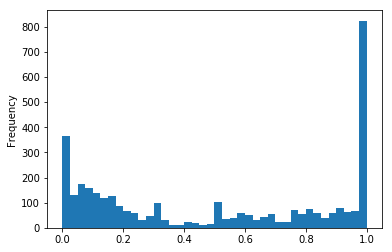

In [97]:
bos_unavail.unavail_percentage.plot(kind='hist',bins=40)

We now have listing information, customers reviews and listing availability. We will be interested in the amount of revenue generated by an Arirbnb property. Although, we cannot use the availability information provided in the calendar .csv since it is most likely tracking when a listing is available for rent and when it is not. We can infer this since there is a large proportion of properties that is unavailable all year round, and it is unlikely that so many properties are rented out the entire year with no gaps in between bookings.

## Build models to predict listing revenues

We will estimate the revenue generated by each Airbnb property with the following formula:

price \* minimum_nights \* number_of_reviews

The number of reviews and minimum_nights will serve as a conservartive estimate of the number of bookings and length of stay respectively. Even though prices do change slightly throughout the years as reflected in the calendar csv, the constant price from listing was used for simplicity. Since we will be working with estimated revenues from 2015 and the listing prices were obtained during August 2016, this assumption should be acceptable. Overall, the estimated revenue will be relatively conservative.

We will build several models to predict Airbnb listing revenues in 2015. The primary purpose will be to analyze the model results and identify which are the most important factors in obtaining higher revenues. Hosts with 0 revenues were removed, since it is likely that they are not actively listing their properties, as evident by the huge proportion of listings with no availabiity.

Only a subset of the original variables will be used. Variables with too many missing values will be dropped, such as weekly prices, monthly prices, etc. In addition, variables with a high amount of text data will be dropped as well. Examples of these are name, description, access, transit, etc. This is done for simplicity sake and to avoid having too many variables as compared to data points.

In [15]:
# get subset of data to work with
bos_reg_data = bos_listings[['id','host_response_time','host_response_rate','host_acceptance_rate',\
                             'host_is_superhost', 'host_listings_count', 'host_total_listings_count',\
                             'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',\
                             'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms',\
                             'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit',\
                             'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',\
                             'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',\
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',\
                             'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy',\
                             'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']]

In [9]:
def generate_bookings_and_revenues_2015(df, reviews_2015_df):
    """
    Generate estimated number of bookings and booking revenues in 2015. Also keep tracks of
    listing_id which have more than 365 days booked. This listings will be removed from all
    future analysis
    
    INPUTS:
        df - dataframe containing subset of columns from listings to be used for modeling
    OUTPUTS:
        reviews_df_2015_agg - dataframe containing number of reviews per listing_id in 2015
    """
    # Rename id column to listing id so that we can merge listings data with reviews data
    df.rename(index=str, columns={"id": "listing_id"},inplace=True)

    # Merge number of 2015 reviews to subset of listings
    df = pd.merge(df, reviews_2015_df, how='left', on='listing_id', validate='one_to_one')

    # Compute estimated total days booked
    df['total_days_booked'] = df['minimum_nights'] * df['number_of_reviews_2015']

    # Compute estimated revenues in 2015
    df['estimated_2015_revenue'] = df['price'] * df['minimum_nights'] *\
    df['number_of_reviews_2015']
    
    # restrict to only people who made income
    df = df[df['estimated_2015_revenue'] > 0]
    df.reset_index(drop=True, inplace=True)
    
    # Store the listing ids which have more than 365 days of booking 
    # This will be for future use
    listings_to_drop = df[df['total_days_booked'] > 365].listing_id
    listings_to_drop = listings_to_drop.tolist()
    
    df = df[df['total_days_booked'] <= 365]
    df.reset_index(drop=True, inplace=True)
    
    return df, listings_to_drop

In [1]:
bos_reg_data, listings_to_drop = generate_bookings_and_revenues_2015(bos_reg_data, bos_reviews_2015_agg)

NameError: name 'generate_bookings_and_revenues_2015' is not defined

In [18]:
bos_reg_data.head()

listing_id  host_response_time  host_response_rate  host_acceptance_rate  \
0     3075044      within an hour               100.0                 100.0   
1        6976  within a few hours               100.0                  88.0   
2     7651065      within an hour               100.0                 100.0   
3     5706985      within an hour                98.0                  96.0   
4     2843445  within a few hours               100.0                 100.0   

  host_is_superhost  host_listings_count  host_total_listings_count  \
0                 f                    1                          1   
1                 t                    1                          1   
2                 t                    1                          1   
3                 f                    5                          5   
4                 t                    2                          2   

  host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
0                    t                      t             Roslindale   
1                    t                      t             Roslindale   
2                    t                      t             Roslindale   
3                    t                      t             Roslindale   
4                    t                      t             Roslindale   

            ...           review_scores_location review_scores_value  \
0           ...                              9.0                 9.0   
1           ...                              9.0                10.0   
2           ...                              9.0                10.0   
3           ...                              9.0                 9.0   
4           ...                             10.0                10.0   

  instant_bookable  cancellation_policy  require_guest_profile_picture  \
0                t             moderate                              f   
1                f             moderate                              t   
2                f             flexible                              f   
3                f               strict                              f   
4                f             moderate                              t   

   require_guest_phone_verification  reviews_per_month number_of_reviews_2015  \
0                                 f               1.30                   17.0   
1                                 f               0.47                    7.0   
2                                 f               2.25                   14.0   
3                                 f               4.00                   17.0   
4                                 t               2.38                   41.0   

  total_days_booked  estimated_2015_revenue  
0              34.0                  2210.0  
1              21.0                  1365.0  
2              28.0                  2212.0  
3              17.0                  1700.0  
4              41.0                  3075.0  

[5 rows x 42 columns]

In [19]:
listings_to_drop

[735970,
 3693850,
 5882411,
 5364137,
 1445064,
 6432655,
 3412990,
 3420221,
 8034092,
 4278873]

In [20]:
def process_categorical(df):
    """
    Returned modeling data with categorical features encoded. Also fills any missing values in the
    modeling data. Lastly scale all required variables. Will not process amenities variable
    
    INPUTS:
        df - dataframe containing subset of columns from listings to be used for modeling
    OUTPUTS:
        df - dataframe with all the categorical features processed
    """
    # Label Encode true/false into 1/0 variables
    var_to_lab_enc = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',\
                      'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
    for var in var_to_lab_enc:
        df[var] = np.where(df[var] == "t", 1, 0)
        
    # Engineer new categorical interaction features: property_room_type, property_accomodates, room_type_accomodates
    df['property_room_type'] = df['property_type'] + "_" + df['room_type']
    df['property_accomodates'] = df['property_type'] + "_" + df['accommodates'].map(str)
    df['room_type_accomodates'] = df['room_type'] + "_" + df['accommodates'].map(str)
    
    # Engineer Categorical variables
    # Also engineer an nan column for each of them
    cat_var_to_enc = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type',\
                      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cancellation_policy',\
                      'property_room_type', 'property_accomodates', 'room_type_accomodates'
                     ]

    for var in cat_var_to_enc:
        df = pd.concat([df.drop(var, axis=1),\
                        pd.get_dummies(df[var],\
                                       prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)
    
    # If security_deposit is null, then its likely there are no security deposit. 
    # Same principle for cleaning_fee and estimated_2015_revenue (shouldn't happen)
    fill_with_0_col = ['security_deposit', 'cleaning_fee', 'estimated_2015_revenue']

    # Fill the rest with mean values
    fill_with_mean_col = ['host_response_rate','host_acceptance_rate', 'review_scores_rating', 'review_scores_accuracy',\
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',\
                      'review_scores_location', 'review_scores_value', 'reviews_per_month']

    imp=Imputer(strategy="mean")
    df[fill_with_mean_col] = imp.fit_transform(df[fill_with_mean_col])

    df[fill_with_0_col] = df[fill_with_0_col].fillna(0)
    
    # scale variables
    col_to_scale = ['host_response_rate','host_acceptance_rate','host_listings_count', 'host_total_listings_count',\
                    'price', 'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'availability_365',\
                    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',\
                    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',\
                    'reviews_per_month']

    ss = StandardScaler()
    df_scaled_col = pd.DataFrame(ss.fit_transform(df[col_to_scale]))
    df_scaled_col.columns = col_to_scale

    '''
    mm = MinMaxScaler()
    bos_scaled_col = pd.DataFrame(mm.fit_transform(bos_reg_data[col_to_scale]))
    bos_scaled_col.columns = col_to_scale
    '''
    
    df.drop(columns=col_to_scale, inplace=True)
    df = pd.concat([df, df_scaled_col],axis=1)
    
    return df

In [21]:
bos_reg_data = process_categorical(bos_reg_data)

In [22]:
bos_reg_data.head()

listing_id  host_is_superhost  host_has_profile_pic  \
0     3075044                  0                     1   
1        6976                  1                     1   
2     7651065                  1                     1   
3     5706985                  0                     1   
4     2843445                  1                     1   

   host_identity_verified  is_location_exact  \
0                       1                  1   
1                       1                  1   
2                       1                  1   
3                       1                  0   
4                       1                  1   

                                           amenities  minimum_nights  \
0  {TV,Internet,"Wireless Internet","Air Conditio...               2   
1  {TV,"Cable TV","Wireless Internet","Air Condit...               3   
2  {Internet,"Wireless Internet","Air Conditionin...               2   
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...               1   
4  {TV,Internet,"Wireless Internet","Air Conditio...               1   

   instant_bookable  require_guest_profile_picture  \
0                 1                              0   
1                 0                              1   
2                 0                              0   
3                 0                              0   
4                 0                              1   

   require_guest_phone_verification        ...          availability_365  \
0                                 0        ...                  1.107981   
1                                 0        ...                  0.814708   
2                                 0        ...                  0.924685   
3                                 0        ...                  0.998003   
4                                 1        ...                  1.151972   

   number_of_reviews  review_scores_rating  review_scores_accuracy  \
0          -0.022539              0.270051                0.727529   
1           0.084205              0.756285                0.727529   
2          -0.171980              0.877844                0.727529   
3           0.425786             -0.216182                0.727529   
4           0.639273              0.513168                0.727529   

   review_scores_cleanliness  review_scores_checkin  \
0                  -0.257641               0.552886   
1                  -0.257641               0.552886   
2                   0.730730               0.552886   
3                   0.730730               0.552886   
4                   0.730730               0.552886   

   review_scores_communication  review_scores_location  review_scores_value  \
0                     0.530807               -0.448472            -0.156017   
1                     0.530807               -0.448472             0.970365   
2                     0.530807               -0.448472             0.970365   
3                     0.530807               -0.448472            -0.156017   
4                     0.530807                0.748228             0.970365   

   reviews_per_month  
0          -0.226356  
1          -0.677019  
2           0.289463  
3           1.239656  
4           0.360049  

[5 rows x 233 columns]

In [23]:
# processing and encoding amenities column

amenities_list = []

for index, row in bos_reg_data.iterrows():
    amenities = ''
    row_amenities = row['amenities']
    # remove all punctuations from string
    row_amenities = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ', row_amenities).strip()
    # remove all duplicated white space from string
    row_amenities = re.sub(' +', ' ',row_amenities)
    amenities += row_amenities
    amenities_list.append(amenities)

bos_reg_data['amenities'] = amenities_list

In [24]:
# quick and dirty way to process amenities
'''
tf = TfidfVectorizer(ngram_range=(1,3), lowercase=True, max_features=60)
tfidf_df = tf.fit_transform(bos_reg_data['amenities'])
print(tf.get_feature_names())
'''

cv = CountVectorizer(ngram_range=(1,5), lowercase=True, max_features=250)
cv_df = cv.fit_transform(bos_reg_data['amenities'])
print(cv.get_feature_names())

['24', '24 hour', '24 hour check', '24 hour check in', '24 hour check in hangers', '50', 'aid', 'aid kit', 'aid kit fire', 'air', 'air conditioning', 'air conditioning kitchen', 'air conditioning kitchen free', 'air conditioning kitchen free parking', 'air conditioning kitchen heating', 'amenity', 'amenity 50', 'building', 'buzzer', 'buzzer wireless', 'buzzer wireless intercom', 'buzzer wireless intercom heating', 'buzzer wireless intercom heating family', 'cable', 'cable tv', 'cable tv internet', 'cable tv internet wireless', 'cable tv internet wireless internet', 'carbon', 'carbon monoxide', 'carbon monoxide detector', 'carbon monoxide detector essentials', 'carbon monoxide detector fire', 'carbon monoxide detector fire extinguisher', 'carbon monoxide detector first', 'carbon monoxide detector first aid', 'check', 'check in', 'check in hangers', 'check in hangers hair', 'check in hangers hair dryer', 'conditioning', 'conditioning kitchen', 'conditioning kitchen free', 'conditioning k

In [25]:
# Put results of word vertorizer into a dataframe
'''
tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tf.get_feature_names())
tfidf_df.head()
'''

cv_df = pd.DataFrame(cv_df.toarray(), columns=cv.get_feature_names())
cv_df.head()

24  24 hour  24 hour check  24 hour check in  24 hour check in hangers  50  \
0   0        0              0                 0                         0   0   
1   0        0              0                 0                         0   1   
2   0        0              0                 0                         0   0   
3   1        1              1                 1                         0   0   
4   0        0              0                 0                         0   0   

   aid  aid kit  aid kit fire  air    ...      wireless  wireless intercom  \
0    0        0             0    1    ...             1                  0   
1    1        1             0    1    ...             1                  0   
2    1        1             0    1    ...             1                  0   
3    1        1             1    0    ...             1                  0   
4    1        1             0    1    ...             1                  0   

   wireless intercom heating  wireless intercom heating family  \
0                          0                                 0   
1                          0                                 0   
2                          0                                 0   
3                          0                                 0   
4                          0                                 0   

   wireless intercom heating family kid  wireless internet  \
0                                     0                  1   
1                                     0                  1   
2                                     0                  1   
3                                     0                  1   
4                                     0                  1   

   wireless internet air  wireless internet air conditioning  \
0                      1                                   1   
1                      1                                   1   
2                      1                                   1   
3                      0                                   0   
4                      1                                   1   

   wireless internet air conditioning kitchen  workspace  
0                                           1          0  
1                                           1          0  
2                                           1          0  
3                                           0          0  
4                                           0          1  

[5 rows x 250 columns]

In [26]:
# Delete columns that don't make sense

cv_col_to_drop = ['24', '24 hour', '24 hour check', '24 hour check in hangers', '50', 'aid', 'aid kit', 'aid kit fire',\
                  'air', 'air conditioning kitchen', 'air conditioning kitchen free', 'air conditioning kitchen free parking',\
                  'air conditioning kitchen heating', 'amenity', 'amenity 50', 'building', 'buzzer wireless',\
                  'buzzer wireless intercom', 'buzzer wireless intercom heating', 'buzzer wireless intercom heating family',\
                  'cable', 'cable tv internet', 'cable tv internet wireless', 'cable tv internet wireless internet',\
                  'carbon', 'carbon monoxide', 'carbon monoxide detector essentials', 'carbon monoxide detector fire',\
                  'carbon monoxide detector fire extinguisher', 'carbon monoxide detector first',\
                  'carbon monoxide detector first aid', 'check', 'check in', 'check in hangers', 'check in hangers hair',\
                  'check in hangers hair dryer', 'conditioning', 'conditioning kitchen', 'conditioning kitchen free',\
                  'conditioning kitchen free parking', 'conditioning kitchen free parking on', 'conditioning kitchen heating',\
                  'detector', 'detector carbon', 'detector carbon monoxide', 'detector carbon monoxide detector',\
                  'detector carbon monoxide detector essentials', 'detector carbon monoxide detector fire',\
                  'detector carbon monoxide detector first', 'detector essentials', 'detector essentials shampoo',\
                  'detector fire', 'detector fire extinguisher', 'detector fire extinguisher essentials', 'detector first',\
                  'detector first aid', 'detector first aid kit', 'detector first aid kit fire', 'dryer iron',\
                  'dryer iron laptop', 'dryer iron laptop friendly', 'dryer iron laptop friendly workspace',\
                  'dryer smoke', 'dryer smoke detector', 'dryer smoke detector carbon', 'dryer smoke detector carbon monoxide',\
                  'elevator in', 'elevator in building', 'en', 'en hosting', 'en hosting amenity',\
                  'en hosting amenity 50', 'essentials shampoo', 'essentials shampoo 24', 'essentials shampoo 24 hour',\
                  'essentials shampoo 24 hour check', 'extinguisher', 'extinguisher essentials',\
                  'extinguisher essentials shampoo', 'family', 'family kid', 'family kid friendly washer',\
                  'family kid friendly washer dryer', 'fire', 'fire extinguisher essentials',\
                  'fire extinguisher essentials shampoo', 'first', 'first aid', 'free', 'free parking', 'free parking on',\
                  'friendly', 'friendly washer', 'friendly washer dryer', 'friendly washer dryer smoke',\
                  'friendly washer dryer smoke detector', 'friendly workspace', 'hair', 'hair dryer iron',\
                  'hair dryer iron laptop', 'hair dryer iron laptop friendly', 'hangers', 'hangers hair', 'hangers hair dryer',\
                  'hangers hair dryer iron', 'hangers hair dryer iron laptop', 'heating', 'heating family',\
                  'heating family kid', 'heating family kid friendly', 'heating family kid friendly washer', 'heating washer',\
                  'heating washer dryer', 'heating washer dryer smoke', 'heating washer dryer smoke detector', 'hosting',\
                  'hosting amenity', 'hosting amenity 50', 'hour', 'hour check', 'hour check in', 'hour check in hangers',\
                  'hour check in hangers hair', 'in', 'in building', 'in hangers', 'in hangers hair', 'in hangers hair dryer',\
                  'in hangers hair dryer iron', 'intercom heating', 'intercom heating family', 'intercom heating family kid',\
                  'intercom heating family kid friendly', 'internet air', 'internet air conditioning',\
                  'internet air conditioning kitchen', 'internet air conditioning kitchen free',\
                  'internet air conditioning kitchen heating', 'internet wireless', 'internet wireless internet',\
                  'internet wireless internet air', 'internet wireless internet air conditioning',\
                  'iron', 'iron laptop', 'iron laptop friendly', 'iron laptop friendly workspace', 'kid', 'kid friendly',\
                  'kid friendly washer', 'kid friendly washer dryer', 'kid friendly washer dryer smoke', 'kit',\
                  'kit fire extinguisher', 'kitchen free', 'kitchen free parking', 'kitchen free parking on',\
                  'kitchen free parking on premises', 'kitchen heating', 'laptop', 'laptop friendly',\
                  'live', 'live on', 'live on this', 'live on this property', 'missing', 'missing en', 'missing en hosting',\
                  'missing en hosting amenity', 'missing en hosting amenity 50', 'monoxide', 'monoxide detector',\
                  'monoxide detector essentials', 'monoxide detector fire', 'monoxide detector fire extinguisher',\
                  'monoxide detector first', 'monoxide detector first aid', 'monoxide detector first aid kit', 'on',\
                  'on premises', 'on this', 'on this property', 'parking', 'parking on', 'parking on premises', 'pets',\
                  'pets live', 'pets live on', 'pets live on this', 'premises', 'property', 'shampoo 24', 'shampoo 24 hour',\
                  'shampoo 24 hour check', 'shampoo 24 hour check in', 'smoke', 'smoke detector carbon',\
                  'smoke detector carbon monoxide', 'smoke detector carbon monoxide detector', 'this', 'this property',\
                  'translation', 'translation missing', 'translation missing en', 'translation missing en hosting',\
                  'translation missing en hosting amenity', 'tv cable', 'tv cable tv', 'tv cable tv internet',\
                  'tv cable tv internet wireless', 'tv internet', 'tv internet wireless', 'tv internet wireless internet',\
                  'tv internet wireless internet air', 'washer dryer', 'washer dryer smoke', 'washer dryer smoke detector',\
                  'washer dryer smoke detector carbon', 'wireless', 'wireless intercom', 'wireless intercom heating',\
                  'wireless intercom heating family', 'wireless intercom heating family kid', 'wireless internet air',\
                  'wireless internet air conditioning', 'wireless internet air conditioning kitchen', 'workspace']

cv_df.drop(columns=cv_col_to_drop, inplace=True)

In [27]:
#tfidf_df.columns
cv_df.columns

Index(['24 hour check in', 'air conditioning', 'buzzer', 'cable tv',
       'carbon monoxide detector', 'dryer', 'elevator', 'essentials',
       'family kid friendly', 'fire extinguisher', 'first aid kit',
       'free parking on premises', 'hair dryer', 'intercom', 'internet',
       'internet kitchen', 'kitchen', 'laptop friendly workspace',
       'pets live on this property', 'shampoo', 'smoke detector', 'tv',
       'washer', 'wireless internet'],
      dtype='object')

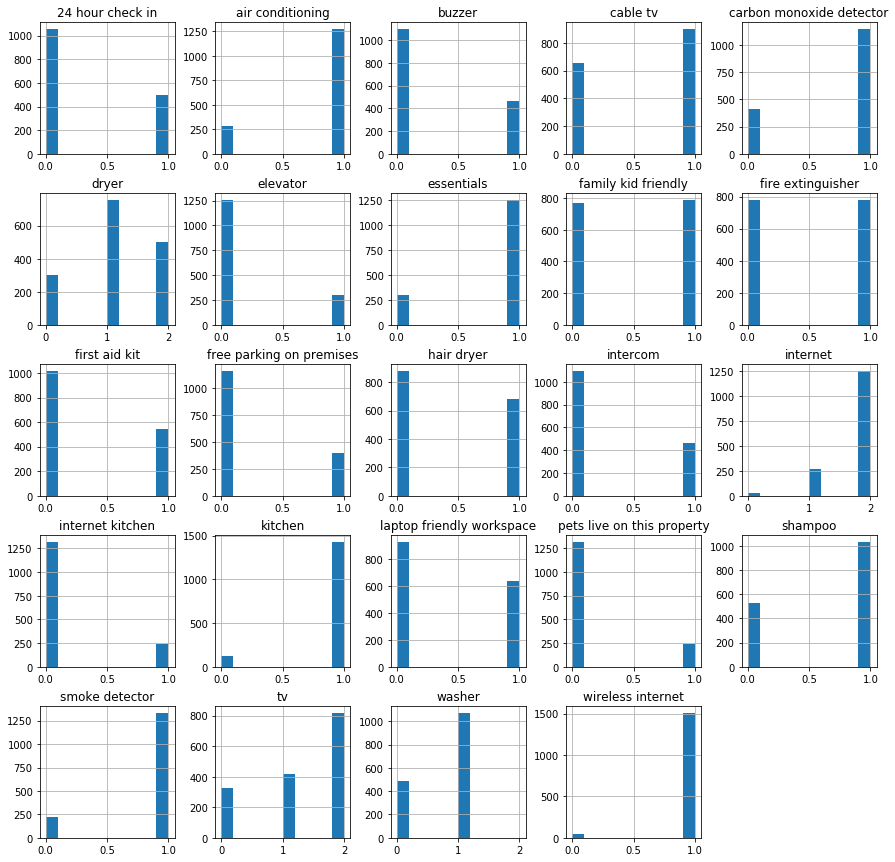

In [28]:
cv_df.hist(figsize=(15,15));

In [29]:
# Fix double counting in internet,tv and dryer. Internet can be double counted with wireless internet, 
# tv with cable tv, dryer with hair dryer

for index, row in cv_df.iterrows():
    if (row['internet'] == 2) and (row['wireless internet'] == 1):
        row['internet'] -= 1
    if (row['tv'] == 2) and (row['cable tv'] == 1):
        row['tv'] -= 1
    if (row['dryer'] == 2) and (row['hair dryer'] == 1):
        row['dryer'] -= 1

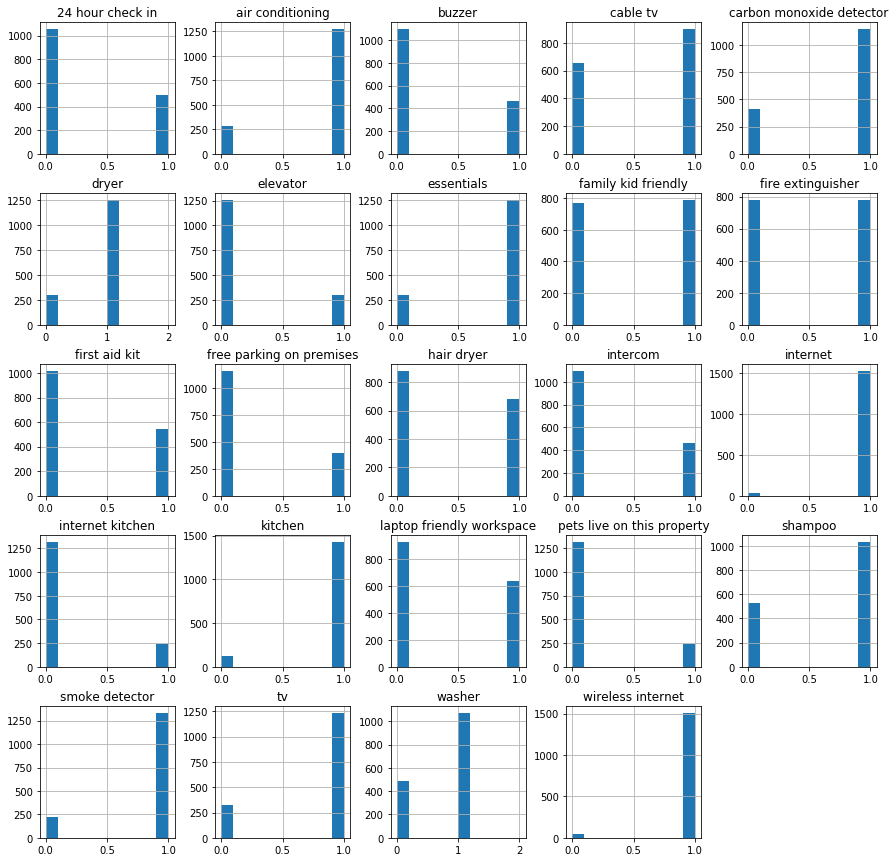

In [30]:
cv_df.hist(figsize=(15,15));

In [31]:
#bos_reg_data = pd.concat([bos_reg_data, tfidf_df],axis=1)
bos_reg_data = pd.concat([bos_reg_data, cv_df],axis=1)
bos_reg_data.head()

listing_id  host_is_superhost  host_has_profile_pic  \
0     3075044                  0                     1   
1        6976                  1                     1   
2     7651065                  1                     1   
3     5706985                  0                     1   
4     2843445                  1                     1   

   host_identity_verified  is_location_exact  \
0                       1                  1   
1                       1                  1   
2                       1                  1   
3                       1                  0   
4                       1                  1   

                                           amenities  minimum_nights  \
0  TV Internet Wireless Internet Air Conditioning...               2   
1  TV Cable TV Wireless Internet Air Conditioning...               3   
2  Internet Wireless Internet Air Conditioning Ki...               2   
3  TV Internet Wireless Internet Kitchen Free Par...               1   
4  TV Internet Wireless Internet Air Conditioning...               1   

   instant_bookable  require_guest_profile_picture  \
0                 1                              0   
1                 0                              1   
2                 0                              0   
3                 0                              0   
4                 0                              1   

   require_guest_phone_verification        ...          internet  \
0                                 0        ...                 1   
1                                 0        ...                 1   
2                                 0        ...                 1   
3                                 0        ...                 1   
4                                 1        ...                 1   

   internet kitchen  kitchen  laptop friendly workspace  \
0                 0        1                          0   
1                 0        1                          0   
2                 0        1                          0   
3                 1        1                          0   
4                 0        0                          1   

   pets live on this property  shampoo  smoke detector  tv  washer  \
0                           1        1               1   1       1   
1                           0        1               1   1       1   
2                           0        1               1   0       0   
3                           0        1               1   1       0   
4                           1        1               1   1       1   

   wireless internet  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  

[5 rows x 257 columns]

In [32]:
# drop 'listing_id', 'amenities', 'minimum_nights', 'number_of_reviews_2015', 'total_days_booked'
bos_reg_data.drop(columns=['listing_id', 'amenities', 'minimum_nights',\
                           'number_of_reviews_2015', 'total_days_booked'],inplace=True)

In [33]:
# Check the columns if they are scaled properly
#bos_reg_data.iloc[0:5,0:20]
#bos_reg_data.iloc[0:5,20:40]
#bos_reg_data.iloc[0:5,40:60]
#bos_reg_data.iloc[0:5,60:80]
#bos_reg_data.iloc[0:5,80:100]
#bos_reg_data.iloc[0:5,100:120]
#bos_reg_data.iloc[0:5,120:140]
#bos_reg_data.iloc[0:5,140:160]
bos_reg_data.iloc[0:5,160:180]
#bos_reg_data.iloc[0:5,180:200]
#bos_reg_data.iloc[0:5,200:220]
#bos_reg_data.iloc[0:5,220:240]
#bos_reg_data.iloc[0:5,240:]

property_accomodates_House_14  property_accomodates_House_16  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   property_accomodates_House_2  property_accomodates_House_3  \
0                             0                             0   
1                             0                             0   
2                             1                             0   
3                             0                             0   
4                             1                             0   

   property_accomodates_House_4  property_accomodates_House_5  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   property_accomodates_House_6  property_accomodates_House_7  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   property_accomodates_House_8  property_accomodates_House_9  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   property_accomodates_Loft_1  property_accomodates_Loft_2  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   property_accomodates_Loft_3  property_accomodates_Loft_4  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   property_accomodates_Other_1  property_accomodates_Other_2  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   property_accomodates_Townhouse_1  property_accomodates_Townhouse_2  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   property_accomodates_Townhouse_3  property_accomodates_Townhouse_4  
0                                 0                                 0  
1                                 0                                 0  
2                                 0                                 0  
3                                 0                                 0  
4                                 0                                 0

In [34]:
# train-valid-test split
train, valid_test = train_test_split(bos_reg_data, test_size=0.2,random_state=1)
valid, test = train_test_split(valid_test, test_size=0.5,random_state=1)

In [35]:
Y_train = train['estimated_2015_revenue']
X_train = train.drop(columns=['estimated_2015_revenue'])

Y_valid = valid['estimated_2015_revenue']
X_valid = valid.drop(columns=['estimated_2015_revenue'])

Y_test = test['estimated_2015_revenue']
X_test = test.drop(columns=['estimated_2015_revenue'])

### Linear Regression

In [36]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
Y_train_pred = lr_model.predict(X_train)
Y_valid_pred = lr_model.predict(X_valid)
Y_test_pred = lr_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

print("Train rmse: {:0.4f} ... Valid rmse: {:0.4f} ... Test rmse: {:0.4f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.4f} ... Valid r2 score: {:0.4f} ... Test r2 score: {:0.4f}".format(train_r2, valid_r2, test_r2))

Train rmse: 5120.4117 ... Valid rmse: 579855478553031.5000 ... Test rmse: 246062751774562.2500
Train r2 score: 0.4734 ... Valid r2 score: -7258626551231981551616.0000 ... Test r2 score: -2134734722399293669376.0000


In [38]:
coefficients_df = pd.DataFrame({"Feature":X_train.columns,"Coefficients":np.transpose(lr_model.coef_)})

In [39]:
coefficients_df.sort_values(by=['Coefficients']).head(20)

Feature  Coefficients
106       property_room_type_Apartment_Entire home/apt -1.353115e+16
107          property_room_type_Apartment_Private room -9.726755e+15
55                                    accommodates_4.0 -7.679158e+15
108           property_room_type_Apartment_Shared room -6.859390e+15
45                             property_type_Townhouse -6.237100e+15
7                host_response_time_a few days or more -5.049734e+15
11                              host_response_time_nan -5.049734e+15
9                host_response_time_within a few hours -5.049734e+15
8                      host_response_time_within a day -5.049734e+15
10                   host_response_time_within an hour -5.049734e+15
116           property_room_type_House_Entire home/apt -3.899331e+15
56                                    accommodates_5.0 -3.895242e+15
119            property_room_type_Loft_Entire home/apt -3.695759e+15
162                       property_accomodates_House_3 -3.403219e+15
166                       property_accomodates_House_7 -3.258676e+15
53                                    accommodates_2.0 -2.951788e+15
155                       property_accomodates_House_1 -2.545406e+15
111            property_room_type_Boat_Entire home/apt -2.302681e+15
109  property_room_type_Bed & Breakfast_Entire home... -2.238803e+15
150                 property_accomodates_Condominium_3 -1.960895e+15

In [40]:
coefficients_df.sort_values(by=['Coefficients'], ascending=False).head(20)

Feature  Coefficients
38                     property_type_Apartment  8.680671e+15
200       room_type_accomodates_Private room_4  7.062401e+15
191    room_type_accomodates_Entire home/apt_4  6.270913e+15
125  property_room_type_Townhouse_Private room  5.679772e+15
199       room_type_accomodates_Private room_3  5.413672e+15
131           property_accomodates_Apartment_2  4.865342e+15
133           property_accomodates_Apartment_4  4.754327e+15
190    room_type_accomodates_Entire home/apt_3  4.622184e+15
176           property_accomodates_Townhouse_2  4.376587e+15
178           property_accomodates_Townhouse_4  4.265572e+15
82                                bedrooms_4.0  4.152603e+15
81                                bedrooms_3.0  4.152603e+15
84                                bedrooms_nan  4.152603e+15
80                                bedrooms_2.0  4.152603e+15
78                                bedrooms_0.0  4.152603e+15
79                                bedrooms_1.0  4.152603e+15
83                                bedrooms_5.0  4.152603e+15
134           property_accomodates_Apartment_5  4.126253e+15
170                property_accomodates_Loft_2  4.011989e+15
48                   room_type_Entire home/apt  3.944071e+15

### Ridge Regression

In [374]:
# Try Ridge Regression
r_model = Ridge(alpha=310)
r_model.fit(X_train, Y_train)

Ridge(alpha=310, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [375]:
Y_train_pred = r_model.predict(X_train)
Y_valid_pred = r_model.predict(X_valid)
Y_test_pred = r_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

print("Train rmse: {:0.4f} ... Valid rmse: {:0.4f} ... Test rmse: {:0.4f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.4f} ... Valid r2 score: {:0.4f} ... Test r2 score: {:0.4f}".format(train_r2, valid_r2, test_r2))

Train rmse: 5508.3963 ... Valid rmse: 5805.1346 ... Test rmse: 3781.5385
Train r2 score: 0.3906 ... Valid r2 score: 0.2725 ... Test r2 score: 0.4958


In [376]:
coefficients_df = pd.DataFrame({"Feature":X_train.columns,"Coefficients":np.transpose(r_model.coef_)})

In [377]:
coefficients_df.sort_values(by=['Coefficients']).head(20)

Feature  Coefficients
234                            essentials   -383.753640
238              free parking on premises   -309.736805
79                           bedrooms_1.0   -270.154843
228                      air conditioning   -255.624654
49                 room_type_Private room   -247.761379
233                              elevator   -244.893074
19      neighbourhood_cleansed_Dorchester   -233.211985
247                        smoke detector   -227.598161
41              property_type_Condominium   -182.658113
11                 host_response_time_nan   -180.980009
211             host_total_listings_count   -160.525627
210                   host_listings_count   -160.525627
29       neighbourhood_cleansed_North End   -158.288362
22          neighbourhood_cleansed_Fenway   -150.073500
42                    property_type_House   -141.356597
57                       accommodates_6.0   -132.689695
198  room_type_accomodates_Private room_2   -132.551227
167          property_accomodates_House_8   -126.013628
80                           bedrooms_2.0   -124.949132
72                          bathrooms_2.5   -114.970479

In [378]:
coefficients_df.sort_values(by=['Coefficients'], ascending=False).head(20)

Feature  Coefficients
212                                         price   2067.255333
218                             number_of_reviews   1760.693443
0                               host_is_superhost    672.157264
226                             reviews_per_month    505.871785
217                              availability_365    437.822804
215                               guests_included    434.277155
106  property_room_type_Apartment_Entire home/apt    375.797399
13                neighbourhood_cleansed_Back Bay    368.912312
209                          host_acceptance_rate    350.078896
38                        property_type_Apartment    340.028846
15             neighbourhood_cleansed_Beacon Hill    321.794966
58                               accommodates_7.0    263.148378
194       room_type_accomodates_Entire home/apt_7    263.148378
213                              security_deposit    259.618229
48                      room_type_Entire home/apt    245.561450
242                              internet kitchen    241.078568
3                               is_location_exact    230.251034
222                         review_scores_checkin    229.363624
229                                        buzzer    227.995277
240                                      intercom    227.995277

### Lasso Regression

In [399]:
l_model = Lasso(alpha=50)
l_model.fit(X_train, Y_train)

Lasso(alpha=50, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [400]:
Y_train_pred = l_model.predict(X_train)
Y_valid_pred = l_model.predict(X_valid)
Y_test_pred = l_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

print("Train rmse: {:0.4f} ... Valid rmse: {:0.4f} ... Test rmse: {:0.4f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.4f} ... Valid r2 score: {:0.4f} ... Test r2 score: {:0.4f}".format(train_r2, valid_r2, test_r2))

Train rmse: 5428.8917 ... Valid rmse: 5867.2376 ... Test rmse: 3735.2756
Train r2 score: 0.4080 ... Valid r2 score: 0.2568 ... Test r2 score: 0.5081


In [401]:
coefficients_df = pd.DataFrame({"Feature":X_train.columns,"Coefficients":np.transpose(l_model.coef_)})

In [402]:
coefficients_df.sort_values(by=['Coefficients']).head(20)

Feature  Coefficients
234                          essentials   -689.718058
233                            elevator   -414.308573
210                 host_listings_count   -389.628987
57                     accommodates_6.0   -389.341870
228                    air conditioning   -374.858425
238            free parking on premises   -288.721212
19    neighbourhood_cleansed_Dorchester   -263.709976
6      require_guest_phone_verification   -195.072239
235                 family kid friendly   -171.252429
247                      smoke detector   -146.302143
224              review_scores_location    -76.078773
79                         bedrooms_1.0    -70.065466
11               host_response_time_nan    -39.098170
49               room_type_Private room    -15.623453
219                review_scores_rating    -13.023741
151  property_accomodates_Condominium_4      0.000000
152  property_accomodates_Condominium_5     -0.000000
153  property_accomodates_Condominium_6     -0.000000
154  property_accomodates_Condominium_8     -0.000000
150  property_accomodates_Condominium_3     -0.000000

In [403]:
coefficients_df.sort_values(by=['Coefficients'], ascending=False).head(20)

Feature  Coefficients
212                                         price   2942.660406
218                             number_of_reviews   2679.973515
0                               host_is_superhost   1478.400705
194       room_type_accomodates_Entire home/apt_7    926.070806
38                        property_type_Apartment    803.052665
13                neighbourhood_cleansed_Back Bay    797.941524
106  property_room_type_Apartment_Entire home/apt    620.324664
15             neighbourhood_cleansed_Beacon Hill    553.025978
242                              internet kitchen    524.454512
209                          host_acceptance_rate    397.951412
244                     laptop friendly workspace    384.240786
215                               guests_included    357.690003
217                              availability_365    335.651725
229                                        buzzer    254.713065
213                              security_deposit    204.899747
239                                    hair dryer    187.474648
214                                  cleaning_fee    152.118320
222                         review_scores_checkin    150.580852
10              host_response_time_within an hour    100.312945
240                                      intercom     71.441617

### XGBoost

In [424]:
params = {'eta': 0.25,\
          'max_depth': 7,\
          'min_child_weight': 40,\
          'objective': 'reg:linear',\
          'eval_metric': 'rmse',\
          'seed': 3,\
          'gamma':1,\
          'silent': True}

In [425]:
watchlist = [
    (xgb.DMatrix(X_train, Y_train), 'train'),
    (xgb.DMatrix(X_valid, Y_valid), 'validation'),
]
xgb_model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 500,  watchlist, maximize=False,\
                      verbose_eval=5, early_stopping_rounds=20)

[0]	train-rmse:7176.12	validation-rmse:7162.71
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 20 rounds.
[5]	train-rmse:4999.61	validation-rmse:5417.34
[10]	train-rmse:4467.05	validation-rmse:5179.03
[15]	train-rmse:4181.76	validation-rmse:5120.16
[20]	train-rmse:4006.7	validation-rmse:5051.68
[25]	train-rmse:3734.36	validation-rmse:4937.92
[30]	train-rmse:3589.65	validation-rmse:4905.62
[35]	train-rmse:3462.75	validation-rmse:4867.21
[40]	train-rmse:3336.2	validation-rmse:4813.86
[45]	train-rmse:3211.74	validation-rmse:4764.58
[50]	train-rmse:3083.35	validation-rmse:4746.68
[55]	train-rmse:2988.56	validation-rmse:4735.6
[60]	train-rmse:2898.94	validation-rmse:4698.09
[65]	train-rmse:2828.34	validation-rmse:4681.71
[70]	train-rmse:2731.54	validation-rmse:4669.7
[75]	train-rmse:2668.59	validation-rmse:4691.29
[80]	train-rmse:2588.05	validation-rmse:4631.4
[85]	train-rmse:2515.58	validation-r

In [426]:
Y_test_pred = xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit)

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

print(test_rmse)
print(test_r2)

3885.6332780751986
0.46767632593230746


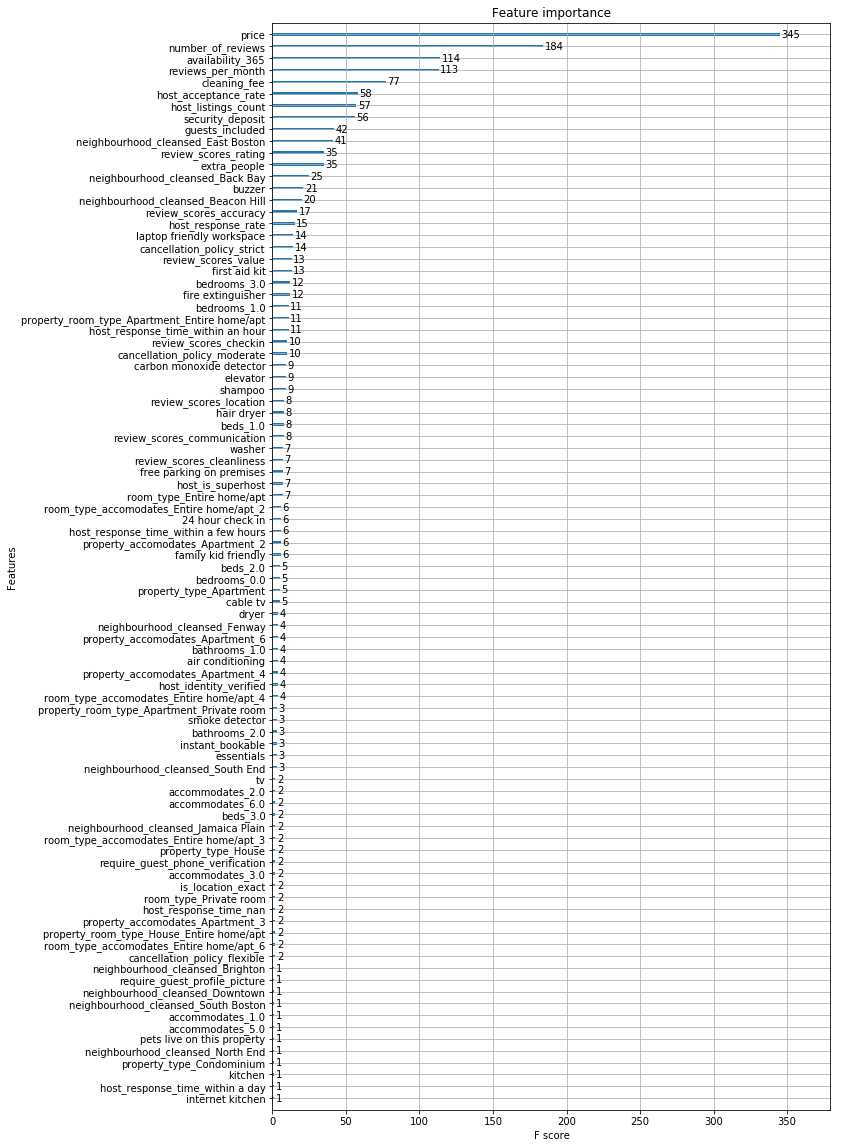

In [427]:
fig, ax = pyplot.subplots(figsize=(10,20));
xgb.plot_importance(xgb_model,ax=ax);

In [428]:
# create SHAP explainer
shap_explainer = shap.TreeExplainer(xgb_model)
# calculate the shapley values for test set
test_shap_vals = shap_explainer.shap_values(X_test)
#train_shap_vals = shap_explainer.shap_values(X_train)

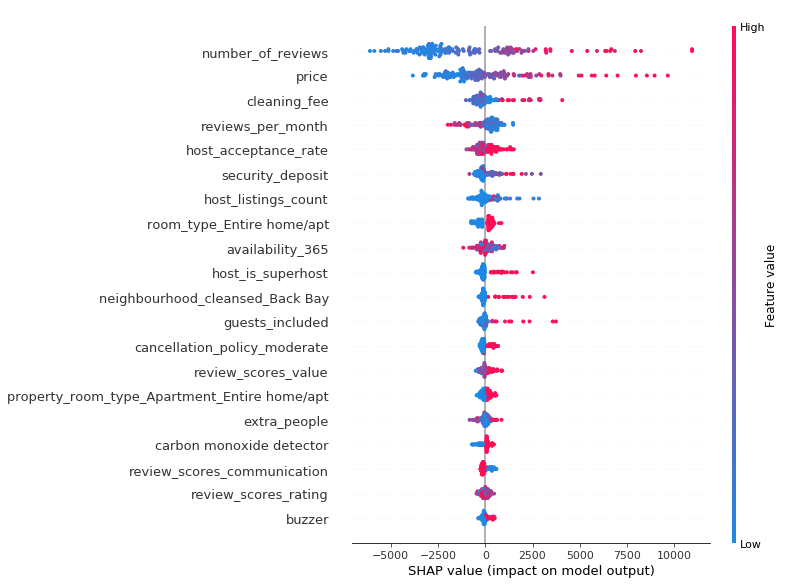

In [429]:
shap.summary_plot(test_shap_vals, X_test, auto_size_plot=True)
#shap.summary_plot(train_shap_vals, X_train, auto_size_plot=True)

A variety of models were tested: linear regression, ridge regression, lasso regression and XGBoost. Since I did not want to lose the interpretability of the results, more complex "black-box" algorithms such as neural networks was avoided.

Since revenue is estimated from listing price, number of reviews and minimum length of stay, we will ignore them and focus on other factors that might be significant in boosting revenue. The model is likely to view the aforementioned variables as significant in the model.

The XGBoost model is the best among all of the models tested, generally having the lowest rmse and highest r-squared value. The model's accuracies in predicting revenues still left a lot to be desired. The average revenue predictions in the test set were off by approximately \$3,900. Considering that the average revenue of a listing is \$4,600, improvements can certainly be made. The r-squared value of the model is 0.468, which is somehwat acceptable.

We will use summary_plot function from the SHAP package to help us interpret the model's results. The color represents the feature value (red high, blue low). Interpreting the top two results of the summary_plot shows us that higher values for number of reviews and price tend to correspond to higher revenues.

An interesting observation is that higher cleaning fees actually resulted in higher revenues. An unexpected observation is that lower number of reviews per month also resulted in higher revenues. being a superhost helped as well. Properties located at Back Bay are also more likely to generate higher revenues. Properties that accomodate more guests will also likely do better. Having a moderate cancellation policy as well as higher review scores values helps. Properties with higher review score ratings for value also do better.

Higher acceptance rate usually leads to higher revenues, but there seem to be exceptions. Renting out an entire home and apartment is also likely to result in higher revenues. Renting an entire apartment is likely to do better. Having a carbon monoxide detector and a buzzer helps. Interestingly, properties with lower review scores for communication also perform better.

Unfortunately, we cannot use the same model on the Seattle datasets since neighbourhoods was used a variable used during training. Both cities have different neighbourhoods, and would require seperate models. Dropping neighbourhoods is likely to result in poorer model performance.

## Q: How much does an Airbnb host make?

In [10]:
# Getting subset of listing data to be used for this section
bos_list_subset = bos_listings[['id', 'name', 'description', 'host_id', 'host_name', 'property_type', 'room_type',\
                                'bathrooms', 'bedrooms', 'amenities', 'price', 'minimum_nights', 'availability_365',\
                                'number_of_reviews', 'host_total_listings_count', 'accommodates', 'cancellation_policy',\
                                'review_scores_value','guests_included', 'host_is_superhost', 'cleaning_fee'                               
                               ]]

In [12]:
bos_list_subset, listings_to_drop = generate_bookings_and_revenues_2015(bos_list_subset, bos_reviews_2015_agg)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'listing_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [13]:
bos_list_subset.head()

listing_id                                 name  \
0     3075044    Charming room in pet friendly apt   
1        6976     Mexican Folk Art Haven in Boston   
2     7651065                  Come Home to Boston   
3     5706985  New Lrg Studio apt 15 min to Boston   
4     2843445   "Tranquility" on "Top of the Hill"   

                                         description   host_id host_name  \
0  Charming and quiet room in a second floor 1910...   2572247    Andrea   
1  Come stay with a friendly, middle-aged guy in ...     16701      Phil   
2  My comfy, clean and relaxing home is one block...  15396970     Linda   
3  It's a 5 minute walk to Rosi Square to catch t...   6570877    Juliet   
4  We can accommodate guests who are gluten-free,...   3164508   Marilyn   

  property_type        room_type  bathrooms  bedrooms  \
0     Apartment     Private room        1.0       1.0   
1     Apartment     Private room        1.0       1.0   
2         House     Private room        1.5       1.0   
3     Apartment  Entire home/apt        1.0       1.0   
4         House     Private room        2.0       1.0   

                                           amenities          ...            \
0  {TV,Internet,"Wireless Internet","Air Conditio...          ...             
1  {TV,"Cable TV","Wireless Internet","Air Condit...          ...             
2  {Internet,"Wireless Internet","Air Conditionin...          ...             
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...          ...             
4  {TV,Internet,"Wireless Internet","Air Conditio...          ...             

   host_total_listings_count  accommodates  cancellation_policy  \
0                          1             2             moderate   
1                          1             2             moderate   
2                          1             2             flexible   
3                          5             3               strict   
4                          2             2             moderate   

   review_scores_value  guests_included  host_is_superhost cleaning_fee  \
0                  9.0                0                  f         10.0   
1                 10.0                1                  t          NaN   
2                 10.0                1                  t         15.0   
3                  9.0                1                  f          NaN   
4                 10.0                1                  t         10.0   

   number_of_reviews_2015  total_days_booked estimated_2015_revenue  
0                    17.0               34.0                 2210.0  
1                     7.0               21.0                 1365.0  
2                    14.0               28.0                 2212.0  
3                    17.0               17.0                 1700.0  
4                    41.0               41.0                 3075.0  

[5 rows x 24 columns]

In [44]:
# check null values
bos_list_subset.isnull().mean()

listing_id                     0.000000
name                           0.000000
description                    0.000000
host_id                        0.000000
host_name                      0.000000
property_type                  0.001281
room_type                      0.000000
bathrooms                      0.005766
bedrooms                       0.003844
amenities                      0.000000
price                          0.000000
minimum_nights                 0.000000
availability_365               0.000000
number_of_reviews              0.000000
host_total_listings_count      0.000000
accommodates                   0.000000
cancellation_policy            0.000000
review_scores_value            0.010250
review_scores_communication    0.008969
guests_included                0.000000
number_of_reviews_2015         0.000000
total_days_booked              0.000000
estimated_2015_revenue         0.000000
dtype: float64

In [45]:
bos_host_income = bos_list_subset.groupby(['host_id', 'host_name']).agg({'estimated_2015_revenue':'sum'}).sort_values(by='estimated_2015_revenue',ascending=False)

In [46]:
# tup hosts income
bos_host_income.head()

estimated_2015_revenue
host_id host_name                        
9410008 Jason                    371081.0
25188   Seamless                 164949.0
434539  Brahma                   158120.0
1444340 Will                     137614.0
9419684 Mike                     116931.0

In [47]:
# Statistics about host revenue in 2015
bos_host_income.estimated_2015_revenue.describe()

count       991.000000
mean       7199.316852
std       17588.991713
min          39.000000
25%         900.000000
50%        2760.000000
75%        7342.000000
max      371081.000000
Name: estimated_2015_revenue, dtype: float64

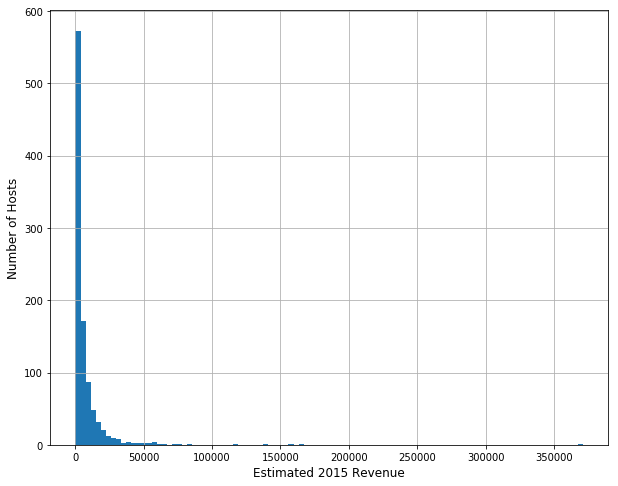

In [48]:
# Plot histogram of host revenue in 2015
fig, ax = plt.subplots(figsize=(10,8));
bos_host_income.estimated_2015_revenue.hist(bins=100, ax=ax);
ax.set_xlabel("Estimated 2015 Revenue", fontsize=12);
ax.set_ylabel("Number of Hosts", fontsize=12);

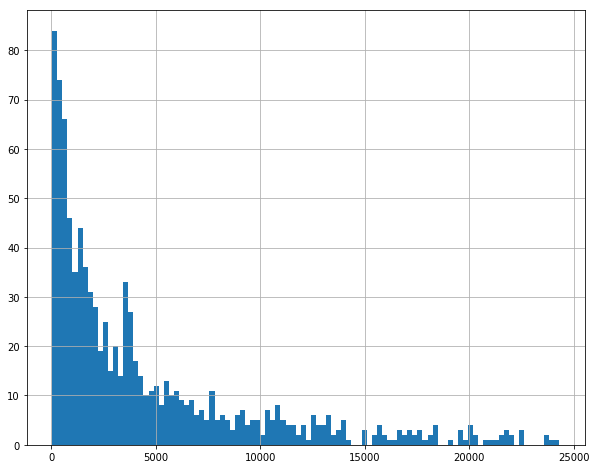

In [49]:
# Plot distribution of revenues below $25,000
bos_host_income[bos_host_income["estimated_2015_revenue"] < 25000].estimated_2015_revenue.hist(bins=100, figsize=(10,8));

In [50]:
# Get only people who list out their properties for more than 90 days in a year
bos_active_list_subset = bos_list_subset[bos_list_subset['availability_365'] >= 90]

In [51]:
bos_active_host_income = bos_active_list_subset.groupby(['host_id','host_name']).agg({'estimated_2015_revenue':'sum'}).sort_values(by='estimated_2015_revenue',ascending=False)

In [52]:
bos_active_host_income.head()

estimated_2015_revenue
host_id host_name                        
9410008 Jason                    371081.0
25188   Seamless                 164949.0
434539  Brahma                   158120.0
1444340 Will                     137614.0
814298  Brent                     75576.0

In [53]:
bos_active_host_income.estimated_2015_revenue.describe()

count       634.000000
mean       9019.694006
std       20539.809954
min          45.000000
25%        1496.250000
50%        3860.000000
75%        9800.750000
max      371081.000000
Name: estimated_2015_revenue, dtype: float64

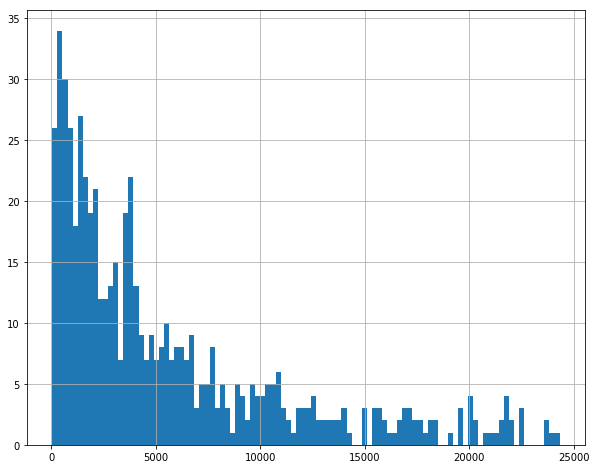

In [54]:
bos_active_host_income[bos_active_host_income["estimated_2015_revenue"] < 25000].estimated_2015_revenue.hist(bins=100, figsize=(10,8));

An Airbnb host in Boston collected an average revenue of \$7,200 in 2015. An active Airbnb host who listed his/her property for more than 90 days in a year (roughly 1/4 of a year) collected an average revenue of \$9,000 in 2015. As seen from the histogram of hosts' revenue, a vast majority of hosts earned little to no revenues,. It is likely because they did not actively list their properties.

The distribution of the revenues of hosts is also right-skewed, suggesting that the ordinary host is unlikely to make a lot of money. The revenue gap between top hosts and the ordinary host is relatively large.

## Q: How much does an Airbnb listing make?

In [55]:
# Plot propertion of each property type
bos_proportion_property = bos_list_subset.groupby(['property_type']).agg({'listing_id':'count'})
bos_proportion_property.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)
bos_proportion_property.sort_values(by='number_of_listings', ascending=False, inplace=True)

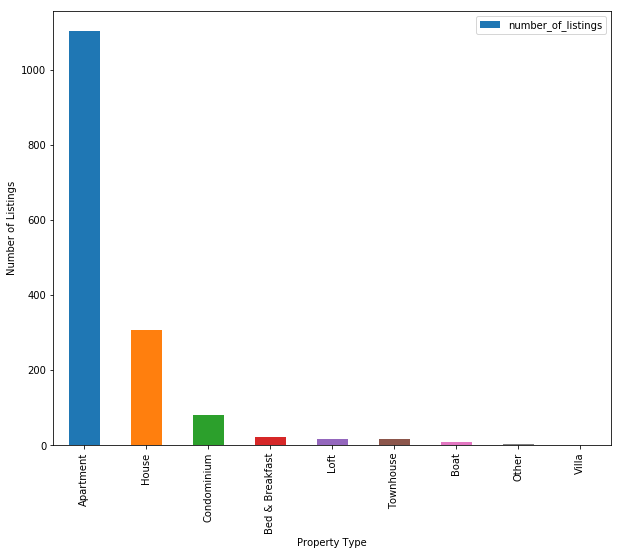

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
bos_proportion_property.plot.bar(y='number_of_listings', ax=ax)
ax.set_xlabel("Property Type")
ax.set_ylabel("Number of Listings")
fig.savefig("boston_proportion_property.jpg", bbox_inches='tight')

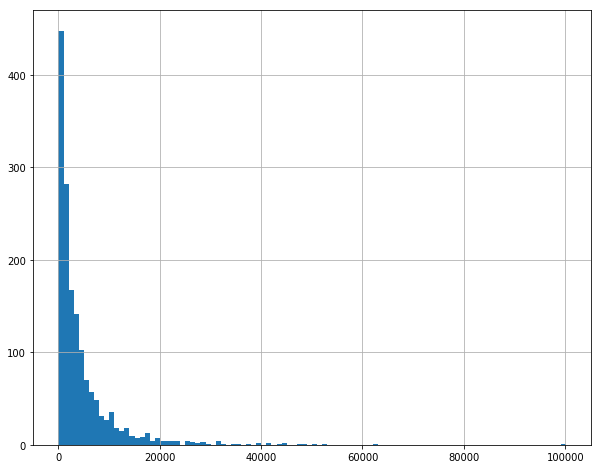

In [57]:
bos_list_subset['estimated_2015_revenue'].hist(figsize=(10,8),bins=100);

In [58]:
bos_list_subset['estimated_2015_revenue'].describe()

count      1561.000000
mean       4570.482383
std        6879.057780
min          32.000000
25%         876.000000
50%        2275.000000
75%        5520.000000
max      100080.000000
Name: estimated_2015_revenue, dtype: float64

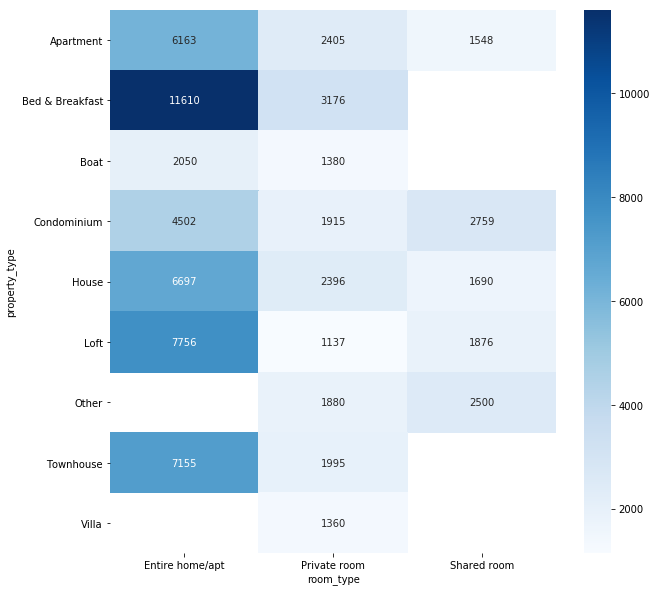

In [59]:
# heatmap of revenue vs property and room type
fig, ax = plt.subplots(figsize=(10,10));
bos_heat = sns.heatmap(bos_list_subset.groupby(['property_type','room_type']).estimated_2015_revenue.mean().unstack(),cmap="Blues",annot=True, fmt=".0f",ax=ax);
fig = bos_heat.get_figure()
fig.savefig("boston_prop_room_heatmap.jpg", bbox_inches='tight')

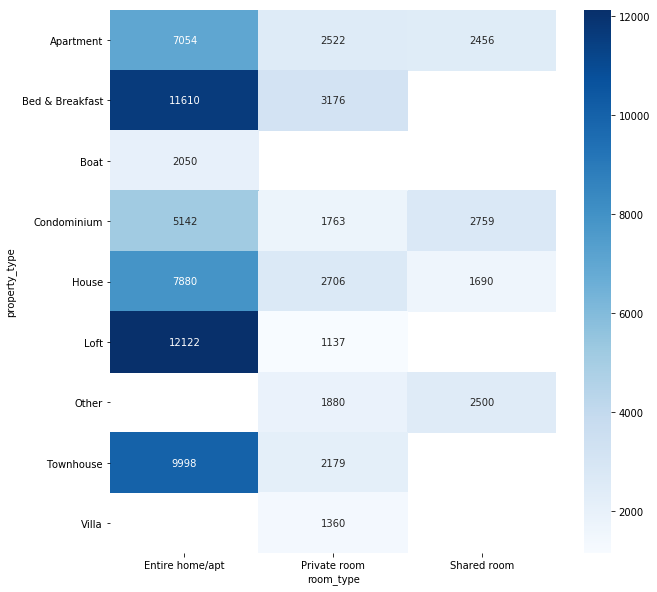

In [60]:
# heatmap of revenue vs property and room type for active hosts
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(bos_active_list_subset.groupby(['property_type','room_type']).estimated_2015_revenue.mean().unstack(),cmap="Blues",annot=True, fmt=".0f",ax=ax);

In [61]:
# check revenues of entire house
bos_entire_house = bos_list_subset[(bos_list_subset['property_type'] == "House") &\
                                   (bos_list_subset['room_type'] == "Entire home/apt")]
bos_entire_house.estimated_2015_revenue.describe()

count       77.000000
mean      6697.233766
std       7996.337081
min        300.000000
25%       1770.000000
50%       3600.000000
75%       9075.000000
max      47610.000000
Name: estimated_2015_revenue, dtype: float64

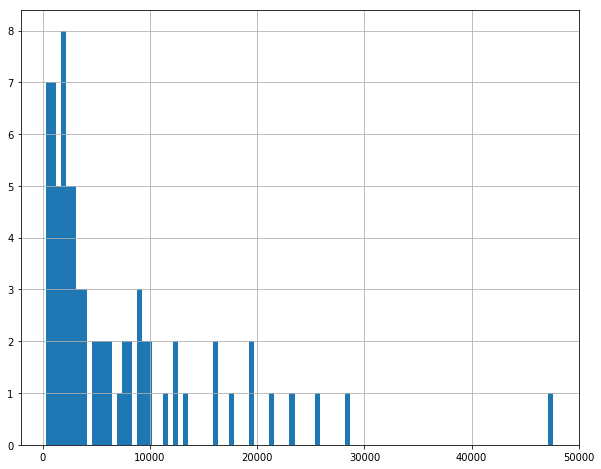

In [62]:
bos_entire_house.estimated_2015_revenue.hist(figsize=(10,8),bins=100);

In [63]:
# check revenues of entire apartment
bos_entire_apart = bos_list_subset[(bos_list_subset['property_type'] == "Apartment") &\
                                   (bos_list_subset['room_type'] == "Entire home/apt")]
bos_entire_apart.estimated_2015_revenue.describe()

count       759.000000
mean       6162.818182
std        8581.765229
min          75.000000
25%        1252.500000
50%        3402.000000
75%        7499.000000
max      100080.000000
Name: estimated_2015_revenue, dtype: float64

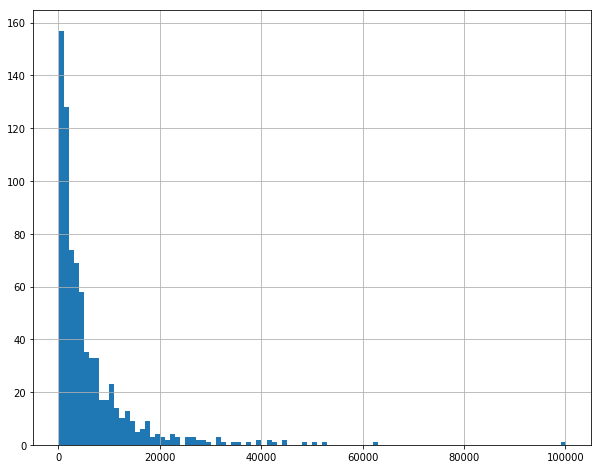

In [64]:
bos_entire_apart.estimated_2015_revenue.hist(figsize=(10,8),bins=100);

In [65]:
# check revenues of entire loft
bos_entire_loft = bos_list_subset[(bos_list_subset['property_type'] == "Loft") &\
                                   (bos_list_subset['room_type'] == "Entire home/apt")]
bos_entire_loft.estimated_2015_revenue.describe()

count       14.000000
mean      7756.285714
std       9288.936044
min        100.000000
25%        957.500000
50%       3940.000000
75%      12492.000000
max      31500.000000
Name: estimated_2015_revenue, dtype: float64

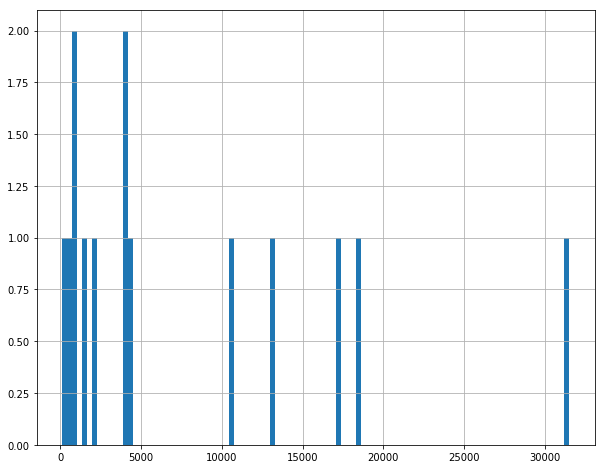

In [66]:
bos_entire_loft.estimated_2015_revenue.hist(figsize=(10,8),bins=100);

In [67]:
# check revenues of entire townhouse
bos_entire_town = bos_list_subset[(bos_list_subset['property_type'] == "Townhouse") &\
                                   (bos_list_subset['room_type'] == "Entire home/apt")]
bos_entire_town.estimated_2015_revenue.describe()

count        5.00000
mean      7155.00000
std       6722.12392
min       1880.00000
25%       2145.00000
50%       3900.00000
75%      10350.00000
max      17500.00000
Name: estimated_2015_revenue, dtype: float64

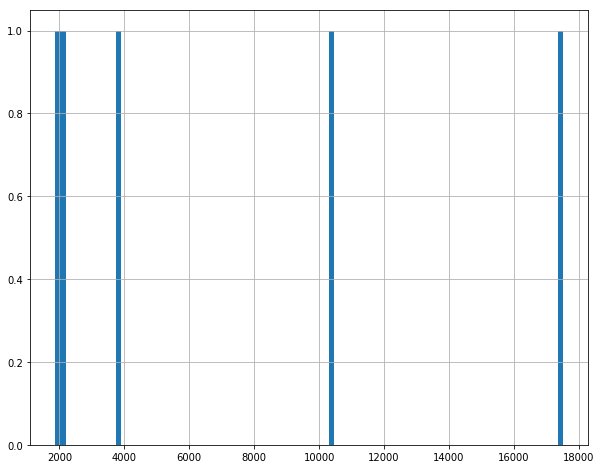

In [68]:
bos_entire_town.estimated_2015_revenue.hist(figsize=(10,8),bins=100);

In [69]:
# Revenue statistics of listings with moderate cancellation policy
bos_list_subset[bos_list_subset['cancellation_policy'] == "moderate"].estimated_2015_revenue.describe()

count      452.000000
mean      4629.685841
std       5946.596392
min         65.000000
25%       1012.500000
50%       2600.000000
75%       5885.250000
max      41580.000000
Name: estimated_2015_revenue, dtype: float64

In [70]:
# Revenue statistics of listings without moderate cancellation policy
bos_list_subset[bos_list_subset['cancellation_policy'] != "moderate"].estimated_2015_revenue.describe()

count      1109.000000
mean       4546.352570
std        7227.039091
min          32.000000
25%         820.000000
50%        2120.000000
75%        5278.000000
max      100080.000000
Name: estimated_2015_revenue, dtype: float64

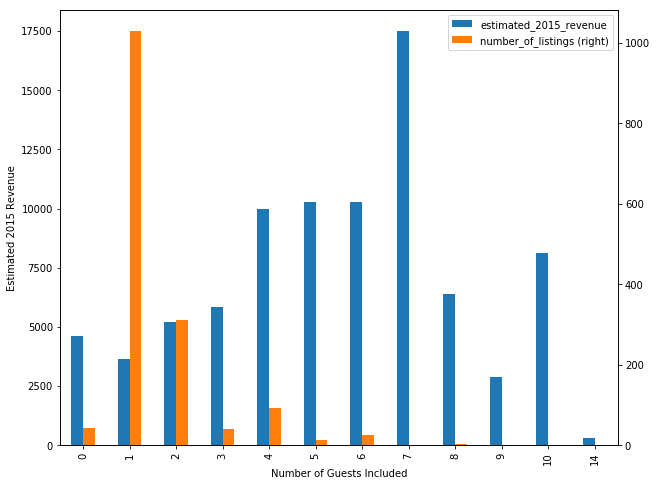

In [71]:
# Plot estimated revenues vs number of guests

bos_num_guests_vs_rev = bos_list_subset.groupby(['guests_included']).agg({'estimated_2015_revenue':'mean','listing_id':'count'})
bos_num_guests_vs_rev.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(10,8))
bos_num_guests_vs_rev.plot.bar(y=['estimated_2015_revenue','number_of_listings'], secondary_y='number_of_listings', ax=ax)
ax.set_xlabel("Number of Guests Included")
ax.set_ylabel("Estimated 2015 Revenue")
fig.savefig("boston_num_guest_rev_property.jpg", bbox_inches='tight')

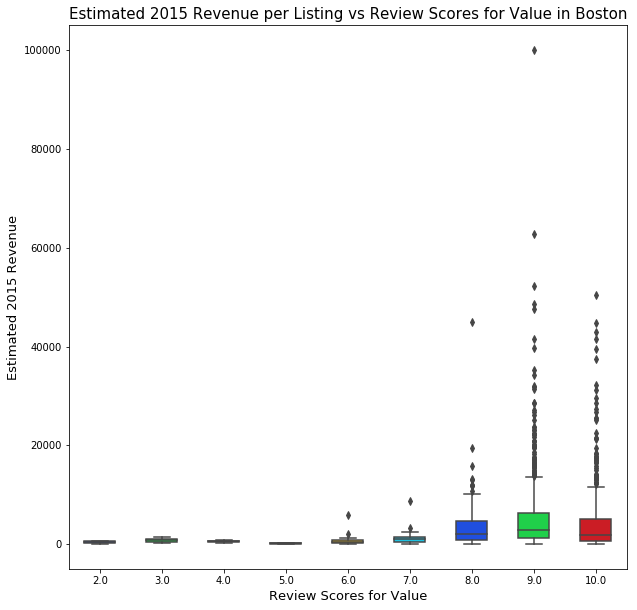

In [14]:
fig, ax = plt.subplots(figsize=(10,10));
bplot = sns.boxplot(y='estimated_2015_revenue',\
                    x='review_scores_value',\
                    data=bos_list_subset,\
                    width=0.5,\
                    palette="bright",\
                    ax=ax
                   )
ax.set_title("Estimated 2015 Revenue per Listing vs Review Scores for Value in Boston", fontsize=15);
ax.set_xlabel("Review Scores for Value", fontsize=13);
ax.set_ylabel("Estimated 2015 Revenue", fontsize=13);
fig.savefig("boston_value_vs_revenue.jpg", bbox_inches='tight');

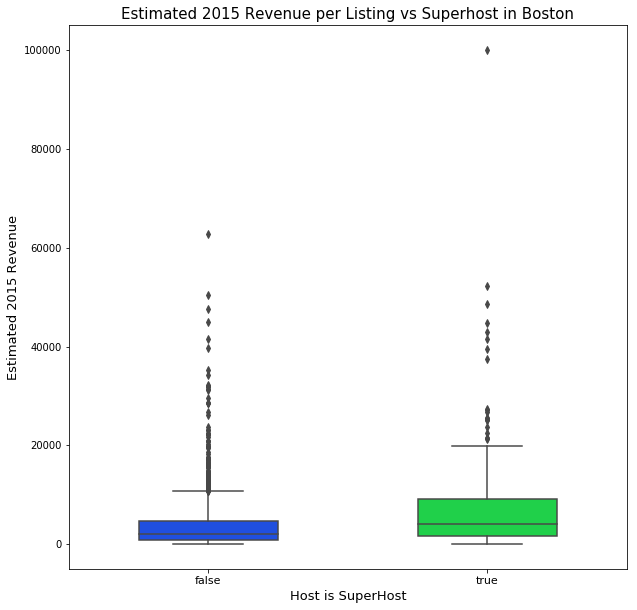

In [15]:
fig, ax = plt.subplots(figsize=(10,10));
bplot = sns.boxplot(y='estimated_2015_revenue',\
                    x='host_is_superhost',\
                    data=bos_list_subset,\
                    width=0.5,\
                    palette="bright",\
                    ax=ax
                   )
ax.set_title("Estimated 2015 Revenue per Listing vs Superhost in Boston", fontsize=15);
ax.set_xlabel("Host is SuperHost", fontsize=13);
ax.set_ylabel("Estimated 2015 Revenue", fontsize=13);
ax.set_xticklabels(['false', 'true'], fontsize=11);
fig.savefig("boston_superhost_vs_revenue.jpg", bbox_inches='tight');

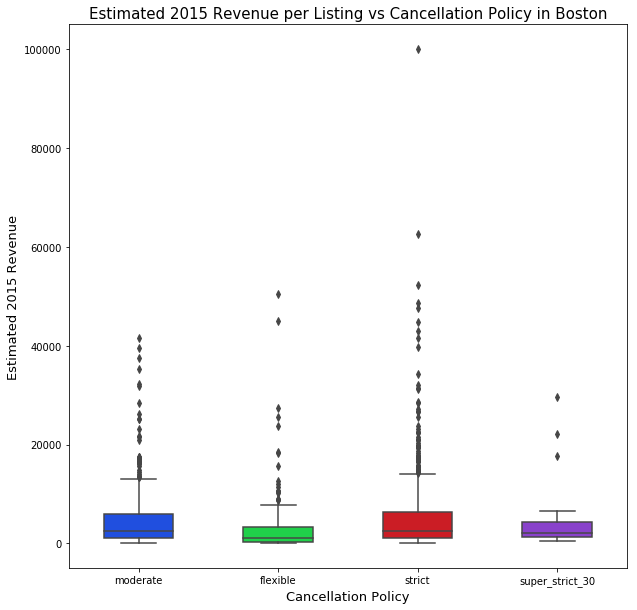

In [16]:
fig, ax = plt.subplots(figsize=(10,10));
bplot = sns.boxplot(y='estimated_2015_revenue',\
                    x='cancellation_policy',\
                    data=bos_list_subset,\
                    width=0.5,\
                    palette="bright",\
                    ax=ax
                   )
ax.set_title("Estimated 2015 Revenue per Listing vs Cancellation Policy in Boston", fontsize=15);
ax.set_xlabel("Cancellation Policy", fontsize=13);
ax.set_ylabel("Estimated 2015 Revenue", fontsize=13);
fig.savefig("boston_cancellation_vs_revenue.jpg", bbox_inches='tight');

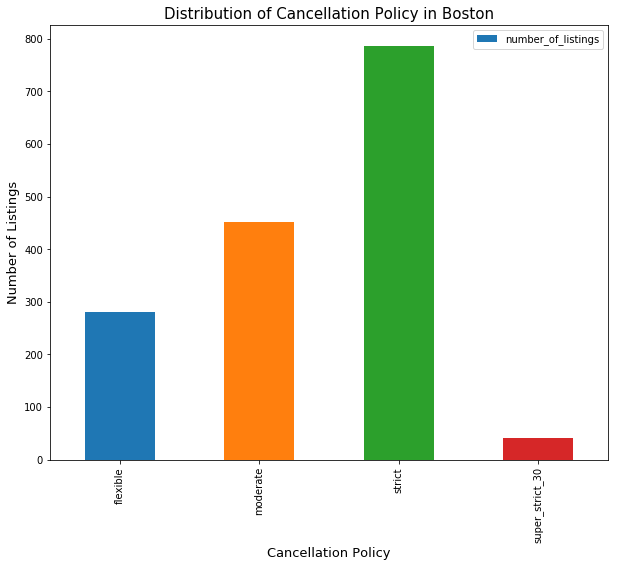

In [17]:
bos_cancel_pol_dist = bos_list_subset.groupby(['cancellation_policy']).agg({'listing_id':'count'})
bos_cancel_pol_dist.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(10,8));
bos_cancel_pol_dist.plot.bar(y='number_of_listings', ax=ax);
ax.set_title("Distribution of Cancellation Policy in Boston", fontsize=15);
ax.set_xlabel("Cancellation Policy", fontsize=13);
ax.set_ylabel("Number of Listings", fontsize=13);
fig.savefig("boston_cancel_pol_dist.jpg", bbox_inches='tight');

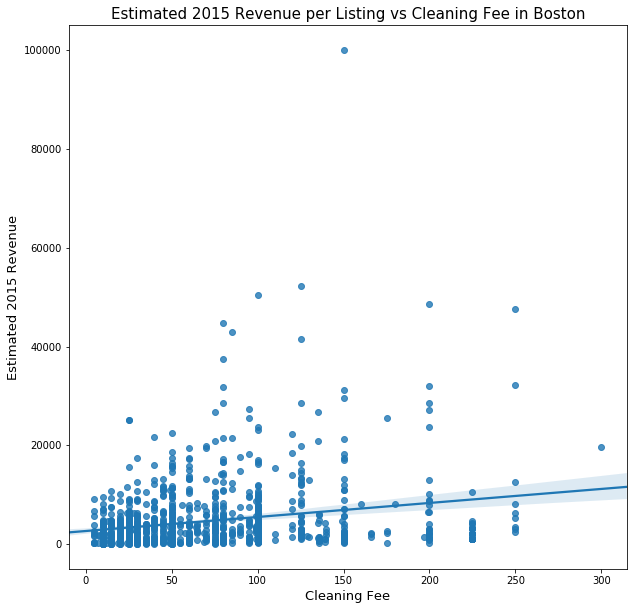

In [18]:
fig, ax = plt.subplots(figsize=(10,10));
sns.regplot(bos_list_subset['cleaning_fee'],bos_list_subset['estimated_2015_revenue'], ax=ax);
ax.set_title("Estimated 2015 Revenue per Listing vs Cleaning Fee in Boston", fontsize=15);
ax.set_xlabel("Cleaning Fee", fontsize=13);
ax.set_ylabel("Estimated 2015 Revenue", fontsize=13);
fig.savefig("boston_clean_vs_rev.jpg", bbox_inches='tight');

The average revenue of a listing is $4,600. This is lower than the average revenue of a host. It is likely that most hosts have more than 1 property. Revenues for listings were also right-skewed, suggesting that there is a sizeable gap between the top and ordinary listings.

Various statistical checks were carried out to confirm the findings from the XGBoost model. Listings with moderate cancellation policies have approximately the same average revenue as listings without it. However, the 25, 50 and 75 percentiles of the revenues of listings with moderate cancellation policies were generally higher. Hence, it is likely having such a policy is beneficial.

To confirm the XGBoost model's result suggesting that revenues increase with number of guests, a bar chart of revenue vs number of guests was plotted. The plot seemed to confirm the model's findings. Listings accomodating 4 guests have revenues that is double that of listings accomodating 3 guests. 

## Q: How should i write my listing's name to get higher revenue?

To compare the names of listings between better-performing listings and weaker-performing pnes, two word clouds will be used. One word cloud will be used to depict the most common words words used in listings ranked among the top 10% of listings in terms of revenue made in 2015. Another word cloud will be used to depict the most common words used in listings ranked in the bottom 30% of listings in terms of revenue made.

In [72]:
bos_list_subset_dropna = bos_list_subset.dropna(how='any', subset=['estimated_2015_revenue'])

In [73]:
# Get all listings in the top 10% of total revenue made in 2015
bos_top_10_percent_list = bos_list_subset_dropna[bos_list_subset_dropna.estimated_2015_revenue >= \
                                                 np.percentile(bos_list_subset_dropna.estimated_2015_revenue,90)]
bos_top_10_percent_list.head()

listing_id                                            name  \
6       849408               Perfect & Practical Boston Rental   
56     4975581                       Clean Apartment in Boston   
59     1109224                  4 bedroom Victorian Condo unit   
68     2875267  Historic Carriage House, a peaceful city oasis   
86     4765070              Private studio w/ private entrance   

                                          description   host_id   host_name  \
6   This is a cozy and spacious two bedroom unit w...   4434391       Damon   
56  Cozy but spacious 3rd floor apartment!  2 Bedr...  12937716  Jean-Ellen   
59  Featuring a fully equipped kitchen, this four-...   1531239        Lita   
68  Newly renovated with pristine, modern decor, t...  14696258       Sarah   
86  Studio Apt. located in Jamaica Plain. This fir...  24584716      Miriam   

   property_type        room_type  bathrooms  bedrooms  \
6      Apartment  Entire home/apt        1.0       2.0   
56     Apartment  Entire home/apt        1.0       2.0   
59     Apartment  Entire home/apt        2.0       4.0   
68     Apartment  Entire home/apt        1.0       0.0   
86         House  Entire home/apt        1.0       0.0   

                                            amenities           ...            \
6   {TV,"Cable TV",Internet,"Wireless Internet","A...           ...             
56  {TV,"Cable TV",Internet,"Wireless Internet","A...           ...             
59  {TV,"Cable TV",Internet,"Wireless Internet","A...           ...             
68  {TV,Internet,"Wireless Internet","Air Conditio...           ...             
86  {TV,"Cable TV",Internet,"Wireless Internet","A...           ...             

    number_of_reviews  host_total_listings_count  accommodates  \
6                  33                          2             5   
56                 47                          1             6   
59                 35                          1             8   
68                148                          2             2   
86                139                          3             2   

    cancellation_policy  review_scores_value  review_scores_communication  \
6                strict                  9.0                         10.0   
56             moderate                  9.0                         10.0   
59               strict                  9.0                         10.0   
68             moderate                 10.0                         10.0   
86             moderate                  9.0                         10.0   

   guests_included  number_of_reviews_2015  total_days_booked  \
6                4                    16.0               64.0   
56               1                    28.0               84.0   
59               6                    13.0               39.0   
68               2                    72.0              144.0   
86               1                    89.0              178.0   

    estimated_2015_revenue  
6                  14656.0  
56                 14112.0  
59                 16731.0  
68                 25200.0  
86                 16020.0  

[5 rows x 23 columns]

In [74]:
def generate_wordcloud(df, save_file_name):
    """
    Generate top words used in listing names for the dataframe in consideration
    
    INPUTS:
        df - dataframe containing subset of listings to be used for wordcloud
    """
    punctuations = string.punctuation
    english_stopwords = stopwords.words("english")
    name_text=''
    for index, row in df.iterrows():
        name_text += " "
        name_text += row['name']
    name_text = nltk.word_tokenize(name_text)
    # Remove, punctuations, stopwords and numbers
    name_text = [word.lower() for word in name_text if word not in punctuations \
                 if not word.isdigit() if word not in english_stopwords]
    wnl = nltk.WordNetLemmatizer()
    name_text = [wnl.lemmatize(word) for word in name_text]
    name_text = ' '.join(name_text)
    name_wordcloud = WordCloud(width=1500,height=1000, background_color='white',\
                           max_words=200, random_state=100).generate(name_text)
    plt.figure(figsize=(15,10));
    plt.imshow(name_wordcloud);
    plt.axis("off");
    plt.show();
    name_wordcloud.to_file(save_file_name)

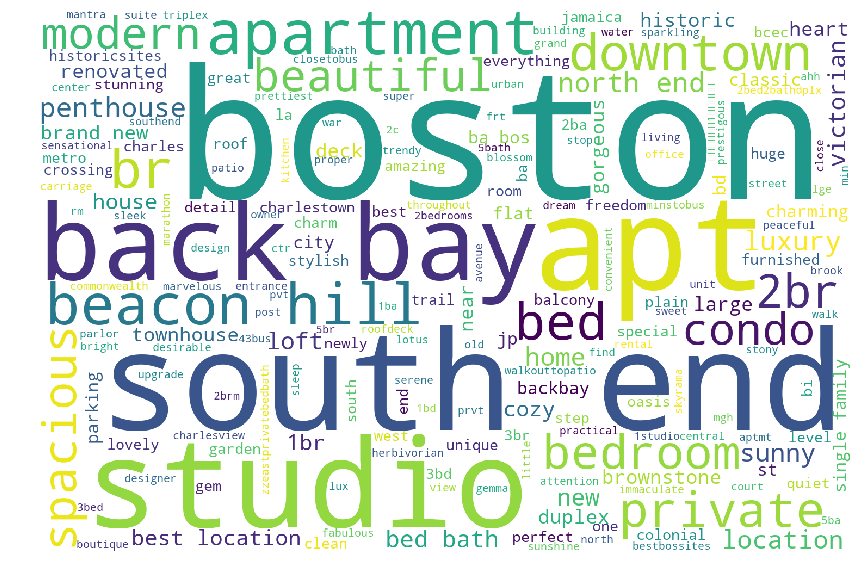

In [75]:
generate_wordcloud(bos_top_10_percent_list, "boston_name_top_10_wordcloud.jpeg")

In [76]:
# Get all listings in the bottom 30% of total revenue made in 2015. Will compare this result with above word cloud 
bos_bot_30_percent_list = bos_list_subset_dropna[bos_list_subset_dropna.estimated_2015_revenue <= \
                                                 np.percentile(bos_list_subset_dropna.estimated_2015_revenue,30)]
bos_bot_30_percent_list.head()

listing_id                                 name  \
7      1668313    Room in Rozzie-Twin Bed-Full Bath   
8      5434353              Quiet  Beauty in Boston   
10     7252607   Private Room near Public Transport   
12      225834               Skyline View to Boston   
17      321328  Bright Room Near Roslindale Village   

                                          description   host_id host_name  \
7   Quiet second floor bedroom sleeps one in comfo...   8834105   Rebecca   
8   Enjoy the full space of our home as you explor...   9658771   Anthony   
10  A handsome colonial house set on a tranquil si...  34552909    Barrie   
12  High atop Metropolitan Hill. Expansive view. N...   1176995     Duane   
17  I have an attractive room available in Roslind...   8302344       Dan   

   property_type        room_type  bathrooms  bedrooms  \
7          House     Private room        1.0       1.0   
8          House  Entire home/apt        1.5       2.0   
10         House     Private room        1.0       1.0   
12     Apartment     Private room        0.0       1.0   
17     Apartment     Private room        1.0       1.0   

                                            amenities           ...            \
7   {TV,"Cable TV",Internet,"Wireless Internet","A...           ...             
8   {Internet,"Wireless Internet",Kitchen,"Free Pa...           ...             
10  {TV,Internet,"Wireless Internet","Air Conditio...           ...             
12  {TV,Internet,"Wireless Internet","Air Conditio...           ...             
17  {Internet,"Wireless Internet","Air Conditionin...           ...             

    number_of_reviews  host_total_listings_count  accommodates  \
7                  17                          2             1   
8                   7                          1             2   
10                  4                          3             2   
12                 38                          2             2   
17                 11                          1             2   

    cancellation_policy  review_scores_value  review_scores_communication  \
7              flexible                  9.0                         10.0   
8              moderate                  9.0                          9.0   
10               strict                 10.0                         10.0   
12               strict                  9.0                         10.0   
17             flexible                  9.0                          9.0   

   guests_included  number_of_reviews_2015  total_days_booked  \
7                1                     4.0                4.0   
8                2                     2.0                6.0   
10               1                     2.0               10.0   
12               1                    12.0               12.0   
17               1                     3.0                3.0   

    estimated_2015_revenue  
7                    228.0  
8                    870.0  
10                   490.0  
12                   840.0  
17                   300.0  

[5 rows x 23 columns]

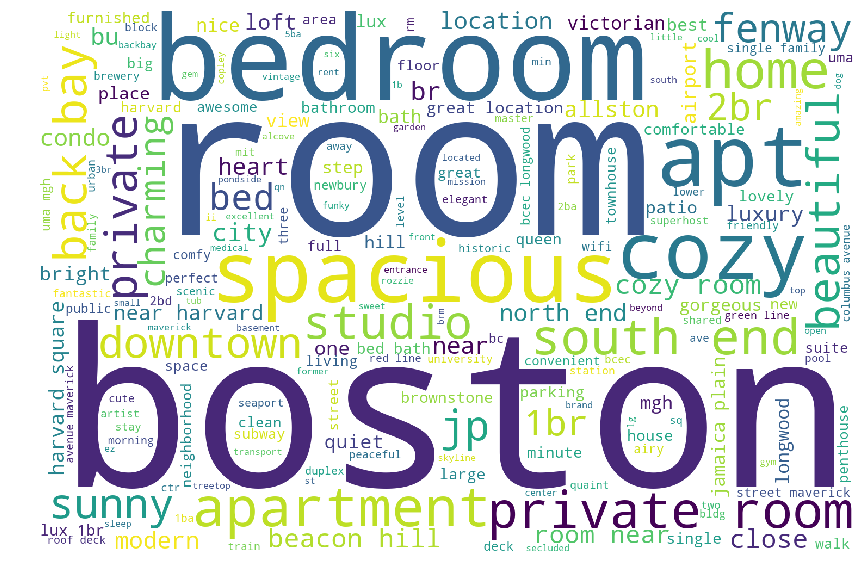

In [77]:
generate_wordcloud(bos_bot_30_percent_list, "boston_name_bot_30_wordcloud.jpeg")

## Q: When is the best time to rent?

In [78]:
bos_reviews.head()

listing_id       id       date  reviewer_id reviewer_name  \
0     1178162  4724140 2013-05-21      4298113       Olivier   
1     1178162  4869189 2013-05-29      6452964     Charlotte   
2     1178162  5003196 2013-06-06      6449554     Sebastian   
3     1178162  5150351 2013-06-15      2215611        Marine   
4     1178162  5171140 2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [79]:
bos_reviews.shape

(68275, 6)

In [80]:
bos_list_price = bos_listings[['id', 'price', 'minimum_nights']]
bos_list_price.rename(index=str, columns={"id": "listing_id"},inplace=True)
bos_list_price.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


listing_id  price  minimum_nights
0    12147973  250.0               2
1     3075044   65.0               2
2        6976   65.0               3
3     1436513   75.0               1
4     7651065   79.0               2

In [81]:
bos_reviews_subset = bos_reviews[['listing_id','id','date']]
bos_reviews_subset.head()

listing_id       id       date
0     1178162  4724140 2013-05-21
1     1178162  4869189 2013-05-29
2     1178162  5003196 2013-06-06
3     1178162  5150351 2013-06-15
4     1178162  5171140 2013-06-16

In [82]:
bos_reviews_subset.shape

(68275, 3)

In [83]:
bos_reviews_subset = pd.merge(bos_reviews_subset, bos_list_price, how='left', on='listing_id')
bos_reviews_subset.head()

listing_id       id       date  price  minimum_nights
0     1178162  4724140 2013-05-21   95.0               1
1     1178162  4869189 2013-05-29   95.0               1
2     1178162  5003196 2013-06-06   95.0               1
3     1178162  5150351 2013-06-15   95.0               1
4     1178162  5171140 2013-06-16   95.0               1

In [84]:
listings_to_drop

[735970,
 3693850,
 5882411,
 5364137,
 1445064,
 6432655,
 3412990,
 3420221,
 8034092,
 4278873]

In [85]:
# Drop listings with more than 365 days booked. Obtained this list from modelling section
for list_id in listings_to_drop:
    bos_reviews_subset = bos_reviews_subset[bos_reviews_subset['listing_id'] != list_id]

In [86]:
bos_reviews_subset.shape

(67679, 5)

In [87]:
bos_reviews_subset['estimated_revenue'] = bos_reviews_subset['price'] * bos_reviews_subset['minimum_nights']
bos_reviews_subset.head()

listing_id       id       date  price  minimum_nights  estimated_revenue
0     1178162  4724140 2013-05-21   95.0               1               95.0
1     1178162  4869189 2013-05-29   95.0               1               95.0
2     1178162  5003196 2013-06-06   95.0               1               95.0
3     1178162  5150351 2013-06-15   95.0               1               95.0
4     1178162  5171140 2013-06-16   95.0               1               95.0

### Plotting monthly total revenue throughout history

In [88]:
bos_reviews_subset.head()

listing_id       id       date  price  minimum_nights  estimated_revenue
0     1178162  4724140 2013-05-21   95.0               1               95.0
1     1178162  4869189 2013-05-29   95.0               1               95.0
2     1178162  5003196 2013-06-06   95.0               1               95.0
3     1178162  5150351 2013-06-15   95.0               1               95.0
4     1178162  5171140 2013-06-16   95.0               1               95.0

In [89]:
bos_reviews_subset['date'] = pd.to_datetime(bos_reviews_subset.date, format='%Y-%m-%d')

In [90]:
bos_reviews_subset['year'] = bos_reviews_subset['date'].dt.year

In [91]:
bos_reviews_subset['month'] = bos_reviews_subset['date'].dt.month

In [92]:
bos_reviews_monthly_rev = bos_reviews_subset.groupby(['year','month']).agg({'id':'count', 'estimated_revenue':'sum', 'price':'mean'})
bos_reviews_monthly_rev.rename(index=str, columns={"id": "estimated_num_bookings", "price": "average_price"},inplace=True)

In [93]:
bos_reviews_monthly_rev.head()

estimated_num_bookings  estimated_revenue  average_price
year month                                                          
2009 3                           1              435.0          145.0
     4                           1              280.0           40.0
     5                           1              435.0          145.0
     7                           1              195.0           65.0
     8                           2             1170.0          195.0

In [94]:
bos_reviews_monthly_rev = bos_reviews_monthly_rev.reset_index()

In [95]:
date = ['2009-03', '2009-04', '2009-05', '2009-06',
        '2009-07', '2009-08', '2009-09', '2009-10',
        '2009-11', '2009-12', '2010-01', '2010-02',
        '2010-03', '2010-04', '2010-05', '2010-06',
        '2010-07', '2010-08', '2010-09', '2010-10',
        '2010-11', '2010-12', '2011-01', '2011-02',
        '2011-03', '2011-04', '2011-05', '2011-06',
        '2011-07', '2011-08', '2011-09', '2011-10',
        '2011-11', '2011-12', '2012-01', '2012-02',
        '2012-03', '2012-04', '2012-05', '2012-06',
        '2012-07', '2012-08', '2012-09', '2012-10',
        '2012-11', '2012-12', '2013-01', '2013-02',
        '2013-03', '2013-04', '2013-05', '2013-06',
        '2013-07', '2013-08', '2013-09', '2013-10',
        '2013-11', '2013-12', '2014-01', '2014-02',
        '2014-03', '2014-04', '2014-05', '2014-06',
        '2014-07', '2014-08', '2014-09', '2014-10',
        '2014-11', '2014-12', '2015-01', '2015-02',
        '2015-03', '2015-04', '2015-05', '2015-06',
        '2015-07', '2015-08', '2015-09', '2015-10',
        '2015-11', '2015-12', '2016-01', '2016-02',
        '2016-03', '2016-04', '2016-05', '2016-06',
        '2016-07', '2016-08']

In [96]:
bos_reviews_monthly_rev['date'] = date

In [97]:
bos_reviews_monthly_rev.head()

year month  estimated_num_bookings  estimated_revenue  average_price  \
0  2009     3                       1              435.0          145.0   
1  2009     4                       1              280.0           40.0   
2  2009     5                       1              435.0          145.0   
3  2009     7                       1              195.0           65.0   
4  2009     8                       2             1170.0          195.0   

      date  
0  2009-03  
1  2009-04  
2  2009-05  
3  2009-06  
4  2009-07

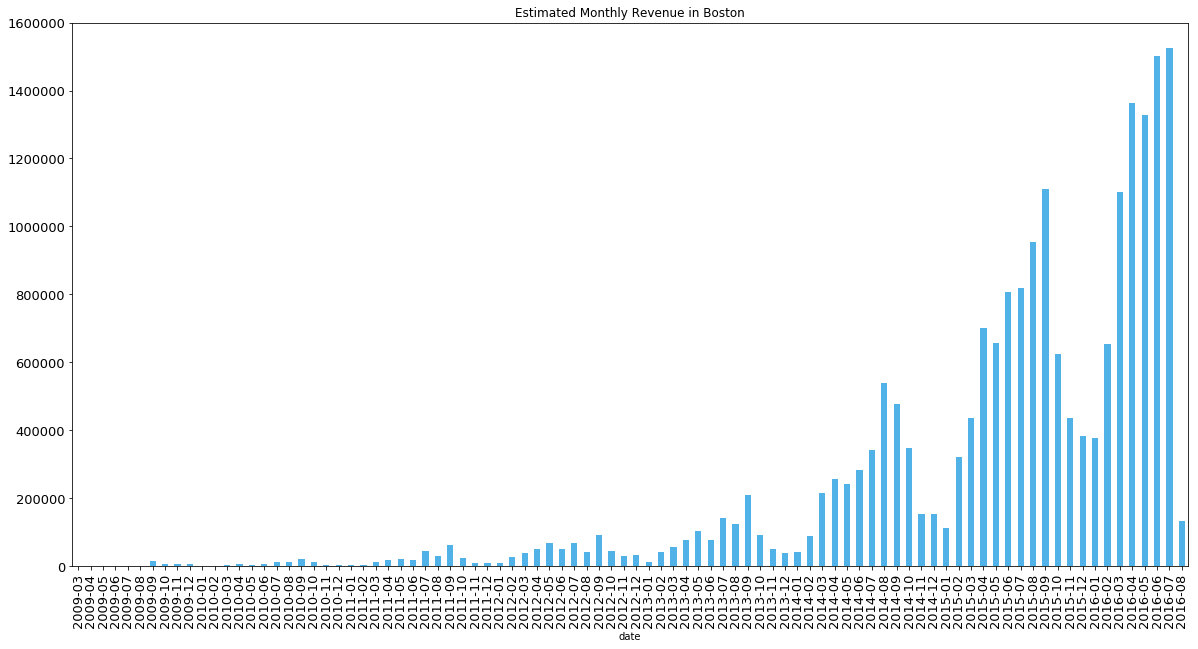

In [98]:
bos_reviews_monthly_rev.plot(kind='bar', x='date', y='estimated_revenue', figsize=(20,10),\
                             color='#51b2e8', fontsize=13, title="Estimated Monthly Revenue in Boston", legend=False);

### Plotting monthly total revenue from 2013 to 2016

In [99]:
# Plot from 2013 onwards to get clearer picture of recent trend
bos_reviews_monthly_rev_2013_2015 = bos_reviews_monthly_rev[bos_reviews_monthly_rev['year'] >= '2013']

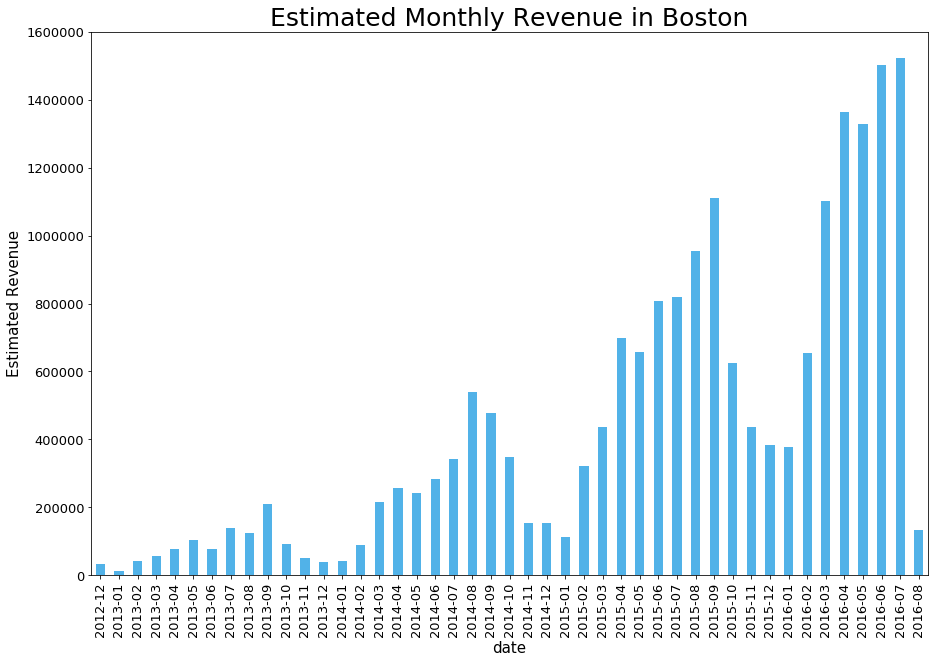

In [100]:
fig, ax = plt.subplots(figsize=(15,10)) 
bos_reviews_monthly_rev_2013_2015.plot(kind='bar', x='date', y='estimated_revenue',\
                             color='#51b2e8', fontsize=13, title="Estimated Monthly Revenue in Boston", legend=False, ax=ax);
ax.set_ylabel("Estimated Revenue", fontsize=15)
ax.set_xlabel("date", fontsize=15)
ax.title.set_size(25)
fig.savefig('boston_revenue.jpg', bbox_inches='tight')

August and September are the peak months in terms of revenue generated for Airbnb listings in Boston. Business also appears to be growing every year, showing no signs of stopping

## Q: Which is the best location to host an Airbnb property?

In [101]:
from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.models import GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, BasicTicker,\
ColorBar, PanTool, WheelZoomTool, BoxSelectTool, LabelSet
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import inferno, magma, cividis
from bokeh.plotting import figure
from bokeh.layouts import row

In [111]:
bos_list_subset = bos_listings[['id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'price', 'minimum_nights']]
bos_list_subset.dropna(axis=0,how='any',inplace=True)
bos_list_subset.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


id neighbourhood_cleansed   latitude  longitude  price  \
0  12147973             Roslindale  42.282619 -71.133068  250.0   
1   3075044             Roslindale  42.286241 -71.134374   65.0   
2      6976             Roslindale  42.292438 -71.135765   65.0   
3   1436513             Roslindale  42.281106 -71.121021   75.0   
4   7651065             Roslindale  42.284512 -71.136258   79.0   

   minimum_nights  
0               2  
1               2  
2               3  
3               1  
4               2

In [112]:
bos_list_subset, listings_to_drop = generate_bookings_and_revenues_2015(bos_list_subset, bos_reviews_2015_agg)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'listing_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [113]:
bos_list_subset.tail()

listing_id neighbourhood_cleansed   latitude  longitude  price  \
1556     6373729                Allston  42.352014 -71.140472   75.0   
1557     7789055                Allston  42.359342 -71.114047  329.0   
1558     3131519            Charlestown  42.374689 -71.074440   72.0   
1559     5280827            Charlestown  42.382681 -71.085720   69.0   
1560     8373729            Charlestown  42.380968 -71.083795   69.0   

      minimum_nights  number_of_reviews_2015  total_days_booked  \
1556               2                     1.0                2.0   
1557               1                    23.0               23.0   
1558               1                     3.0                3.0   
1559               2                     1.0                2.0   
1560               2                     3.0                6.0   

      estimated_2015_revenue  
1556                   150.0  
1557                  7567.0  
1558                   216.0  
1559                   138.0  
1560                   414.0

In [114]:
bos_neigh_rev_df = bos_list_subset.groupby(['neighbourhood_cleansed']).agg({'listing_id': 'count', 'latitude': 'mean', 'longitude': 'mean', 'estimated_2015_revenue': 'mean'})
bos_neigh_rev_df.rename(index=str, columns={"listing_id": "total_num_list"},inplace=True)
bos_neigh_rev_df

total_num_list   latitude  longitude  \
neighbourhood_cleansed                                          
Allston                              90  42.354039 -71.132184   
Back Bay                            132  42.349399 -71.081016   
Bay Village                           9  42.349348 -71.068283   
Beacon Hill                         104  42.359116 -71.067653   
Brighton                             70  42.349373 -71.150819   
Charlestown                          45  42.377960 -71.064044   
Chinatown                            15  42.349835 -71.061699   
Dorchester                          138  42.305785 -71.060578   
Downtown                             69  42.357552 -71.061273   
East Boston                          65  42.376010 -71.029105   
Fenway                               89  42.344766 -71.096072   
Hyde Park                            14  42.253172 -71.118954   
Jamaica Plain                       186  42.311128 -71.110429   
Leather District                      3  42.351512 -71.057791   
Longwood Medical Area                 3  42.339090 -71.104638   
Mattapan                             10  42.275482 -71.082697   
Mission Hill                         44  42.331219 -71.103553   
North End                            70  42.365243 -71.054185   
Roslindale                           35  42.283584 -71.131325   
Roxbury                              76  42.328564 -71.086412   
South Boston                         74  42.335091 -71.047137   
South Boston Waterfront              18  42.346585 -71.046580   
South End                           176  42.342257 -71.073638   
West End                             12  42.363734 -71.067297   
West Roxbury                         14  42.283193 -71.155760   

                         estimated_2015_revenue  
neighbourhood_cleansed                           
Allston                             1883.611111  
Back Bay                            6962.037879  
Bay Village                         2666.444444  
Beacon Hill                         7385.817308  
Brighton                            3452.885714  
Charlestown                         5532.800000  
Chinatown                           6974.933333  
Dorchester                          2311.449275  
Downtown                            6237.434783  
East Boston                         5440.153846  
Fenway                              3220.651685  
Hyde Park                           2559.928571  
Jamaica Plain                       4281.419355  
Leather District                    2386.666667  
Longwood Medical Area               6002.333333  
Mattapan                            1518.300000  
Mission Hill                        2121.840909  
North End                           5862.485714  
Roslindale                          2666.628571  
Roxbury                             4395.276316  
South Boston                        5778.702703  
South Boston Waterfront             4411.166667  
South End                           5109.573864  
West End                            2483.166667  
West Roxbury                        2087.428571

In [115]:
# get only top 10 neighbourhoods in terms of number of listings
bos_neigh_rev_df_10 = bos_neigh_rev_df.sort_values(by=['total_num_list'], ascending=False).head(10)

In [116]:
bos_neigh_rev_df_10

total_num_list   latitude  longitude  \
neighbourhood_cleansed                                         
Jamaica Plain                      186  42.311128 -71.110429   
South End                          176  42.342257 -71.073638   
Dorchester                         138  42.305785 -71.060578   
Back Bay                           132  42.349399 -71.081016   
Beacon Hill                        104  42.359116 -71.067653   
Allston                             90  42.354039 -71.132184   
Fenway                              89  42.344766 -71.096072   
Roxbury                             76  42.328564 -71.086412   
South Boston                        74  42.335091 -71.047137   
Brighton                            70  42.349373 -71.150819   

                        estimated_2015_revenue  
neighbourhood_cleansed                          
Jamaica Plain                      4281.419355  
South End                          5109.573864  
Dorchester                         2311.449275  
Back Bay                           6962.037879  
Beacon Hill                        7385.817308  
Allston                            1883.611111  
Fenway                             3220.651685  
Roxbury                            4395.276316  
South Boston                       5778.702703  
Brighton                           3452.885714

In [117]:
output_file("bos_neigh_rev.html")

map_options = GMapOptions(lat=42.3601, lng=-71.0589, map_type="roadmap", zoom=12)

plot = GMapPlot(api_key=MY_API_KEY, x_range=Range1d(),\
                y_range=Range1d(), map_options=map_options,\
                width=1200, height=750)

plot.title.text = "Boston"

source = ColumnDataSource(
    data=dict(
        lat=bos_neigh_rev_df_10['latitude'],\
        lon=bos_neigh_rev_df_10['longitude'],\
        size=bos_neigh_rev_df_10['total_num_list'] / 2,\
        color=bos_neigh_rev_df_10['estimated_2015_revenue'],\
        neighbourhood=bos_neigh_rev_df_10.index.tolist()
    )
)
# inferno(25)
color_mapper = LinearColorMapper(palette=cividis(25), low=bos_neigh_rev_df_10['estimated_2015_revenue'].min(),\
                                 high=bos_neigh_rev_df_10['estimated_2015_revenue'].max())

circle = Circle(x="lon", y="lat", size="size", fill_color={'field': 'color', 'transform': color_mapper},\
                fill_alpha=0.7, line_color=None)

plot.add_glyph(source, circle)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0),\
                     major_label_text_font_size="14pt"
                    )
#plot.add_layout(color_bar, 'right')

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

labels = LabelSet(background_fill_alpha=0.5, background_fill_color="white", x='lon', y='lat', text='neighbourhood',\
                  text_color="firebrick", text_font_size="19pt", level='glyph', x_offset=-15, y_offset=25,\
                  source=source, render_mode='canvas')


plot.add_layout(labels)

color_bar_height = 750 + 11
color_bar_width = 180

color_bar_plot = figure(title="Estimated 2015 Revenue", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=0, 
                        outline_line_color=None)

color_bar_plot.add_layout(color_bar, 'right')
color_bar_plot.title.align="center"
color_bar_plot.title.text_font_size = '18pt'

layout = row(plot, color_bar_plot)

show(layout)

#show(plot)

We will be plotting a map depicting the average revenue and number of listings available in each neighbourhood. Only the top 10 neighbourhoods in terms of the number of listings available will be shown. This is to reduce the amount of clutter on the map.

Each circle represents a neighbourhood. The colour of the circle indicates the average amount of revenue generated in each neighbourhood, with higher revenues being represented by yellow and lower revenues being represented by blue. The size of the circle reflects the number of listings in the neighbourhood. The map's output will be a html file since the output of the map in the notebook will not always work as expected. Remember to close the html files before running the block of code again to generate a new map.